# Pump it Up: Data Mining the Water Table

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.set_option('display.max_columns', None)
np.random.seed(1)

%matplotlib inline

In [2]:
#Import the datasets
sub_df = pd.read_csv('data/submission_format.csv')
test_vals = pd.read_csv('data/test_set_values.csv')
train_labels = pd.read_csv('data/training_set_labels.csv')
train_vals = pd.read_csv('data/training_set_values.csv')

# Initial Look into the Datasets

In [3]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            14850 non-null  int64 
 1   status_group  14850 non-null  object
dtypes: int64(1), object(1)
memory usage: 232.2+ KB


In [4]:
test_vals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [5]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [6]:
train_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### Merge Training Dataset

We've elected to merge the Training datasets with each well's information and functionality into one.

In [7]:
#Merge the training datatsets
train_merge = train_vals.merge(train_labels, left_on = 'id', right_on = 'id')

In [8]:
train_merge.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

# Exploratory Data Analysis

### Initial Look

In [10]:
train_merge['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [11]:
train_merge['ward'].value_counts()

Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Uchindile            1
Thawi                1
Uwanja wa Ndege      1
Izia                 1
Kinungu              1
Name: ward, Length: 2092, dtype: int64

In [12]:
train_merge['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [13]:
train_merge.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [14]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Check for Duplicate IDs

In [15]:
#Check if any duplicate IDs
train_merge['id'].is_unique

True

No duplicate IDs in our data!

### Check for Duplicate columns

In [16]:
#Who operates the waterpoint
Operators_cols  = train_merge[['scheme_management', 'scheme_name']].value_counts()

#The kind of extraction the waterpoint uses
Extraction_cols  = train_merge[['extraction_type', 'extraction_type_group', 'extraction_type_class']].value_counts()

#How the waterpoint is managed
Management_cols = train_merge[['management', 'management_group']].value_counts()

#What the water costs
Payment_cols = train_merge[['payment', 'payment_type']].value_counts()

#The quality of the water
Quality_cols = train_merge[['water_quality', 'quality_group']].value_counts()

#The quantity of the water
Quantity_cols = train_merge[['quantity', 'quantity_group']].value_counts()

#The source of the water
Source_cols = train_merge[['source', 'source_type', 'source_class']].value_counts()

#The kind of waterpoint
Waterpoint_cols = train_merge[['waterpoint_type', 'waterpoint_type_group']].value_counts()

#Geographic location
Geo_cols = train_merge[['subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']].value_counts()

print(Quality_cols)

water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
dtype: int64


Wow! That's a lot of columns with duplicate data - over 10 columns! Let's do something about that.

### Dropping Columns/Rows

In [17]:
#Drop scheme_name column as well as columns with duplicate data
train_df = train_merge.drop(['scheme_name', 'scheme_management', 'num_private', 'recorded_by', 'extraction_type_class', 
                             'extraction_type_group', 'management_group', 'payment', 'quality_group', 'quantity_group', 
                             'source', 'waterpoint_type_group', 'public_meeting', 'installer', 'funder'], axis=1)

#Drop null values
train_df = train_df.dropna()

We've elected to drop the column 'scheme_name' due to the extensive number of missing values - 28,166 to be precise. 

Additionally, columns with duplicate information were dropped as well. Rows with missing data have been dropped as well as it is a smaller portion of the dataset. 

### Construction Year

In [18]:
#Check the construction years
train_df['construction_year'].value_counts()

0       19219
2008     2576
2009     2491
2010     2429
2000     1566
2007     1558
2006     1447
2003     1276
2011     1209
2004     1109
2002     1065
1978     1027
2012     1026
2005      983
1995      978
1999      953
1985      943
1998      924
1984      779
1996      768
1982      741
1972      704
1994      703
1974      676
1990      667
1980      647
1992      632
1997      613
1993      595
2001      532
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

About a third of our data is has the construction_year equaling to 0. We will keep it as is for now.

# Export Final Dataset

In [19]:
train_df.to_csv('data/train_df.csv')

### Viewing head, info, and some value_counts

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55973 entries, 0 to 59399
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 55973 non-null  int64  
 1   amount_tsh         55973 non-null  float64
 2   date_recorded      55973 non-null  object 
 3   gps_height         55973 non-null  int64  
 4   longitude          55973 non-null  float64
 5   latitude           55973 non-null  float64
 6   wpt_name           55973 non-null  object 
 7   basin              55973 non-null  object 
 8   subvillage         55973 non-null  object 
 9   region             55973 non-null  object 
 10  region_code        55973 non-null  int64  
 11  district_code      55973 non-null  int64  
 12  lga                55973 non-null  object 
 13  ward               55973 non-null  object 
 14  population         55973 non-null  int64  
 15  permit             55973 non-null  object 
 16  construction_year  559

# ONE HOT ENCONDING

In [21]:
#What are the categorical columns
categorical = ['basin', 'region', 'lga', 'extraction_type', 
               'management', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 
               'waterpoint_type']

#What are the continous columns
continuous = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 
              'permit', 'construction_year', 'status_group']

In [22]:
cat_df = train_df[categorical]
cont_df = train_df[continuous]
cat_df

,basin,region,lga,extraction_type,management,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type
0,Lake Nyasa,Iringa,Ludewa,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe
1,Lake Victoria,Mara,Serengeti,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe
2,Pangani,Manyara,Simanjiro,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple
3,Ruvuma / Southern Coast,Mtwara,Nanyumbu,submersible,vwc,never pay,soft,dry,borehole,groundwater,communal standpipe multiple
4,Lake Victoria,Kagera,Karagwe,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...
59395,Pangani,Kilimanjaro,Hai,gravity,water board,per bucket,soft,enough,spring,groundwater,communal standpipe
59396,Rufiji,Iringa,Njombe,gravity,vwc,annually,soft,enough,river/lake,surface,communal standpipe
59397,Rufiji,Mbeya,Mbarali,swn 80,vwc,monthly,fluoride,enough,borehole,groundwater,hand pump
59398,Rufiji,Dodoma,Chamwino,nira/tanira,vwc,never pay,soft,insufficient,shallow well,groundwater,hand pump


In [23]:
#num of unique values in 
c = 0
for column in cat_df:
    print(column,":",len(train_df[column].unique()))
    c+= len(train_df[column].unique())

basin : 9
region : 21
lga : 121
extraction_type : 18
management : 12
payment_type : 7
water_quality : 8
quantity : 5
source_type : 7
source_class : 3
waterpoint_type : 7


In [24]:
#instantiate OHE
ohe = OneHotEncoder()

#fit_transform
X_cat = ohe.fit_transform(cat_df).toarray()

X_cat = pd.DataFrame(X_cat, columns = ohe.get_feature_names_out(categorical))

In [25]:
X_cat

,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_Arusha Rural,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [26]:
#Reset the indexes 
X_cat = X_cat.reset_index(drop=True)
cont_df = cont_df.reset_index(drop=True)

#combine the OHE categorical and continuous data back into one dataset
data_onehot = pd.concat([cont_df,X_cat], axis=1, ignore_index=True)

In [27]:
cont_df.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'permit', 'construction_year',
       'status_group'],
      dtype='object')

In [28]:
data_onehot.columns =list(cont_df.columns) + list(X_cat.columns)
data_onehot

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,status_group,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_Arusha Rural,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,1390,34.938093,-9.856322,11,5,109,False,1999,functional,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [29]:
data_onehot

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,status_group,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,lga_Arusha Rural,lga_Babati,lga_Bagamoyo,lga_Bahi,lga_Bariadi,lga_Biharamulo,lga_Bukoba Rural,lga_Bukoba Urban,lga_Bukombe,lga_Bunda,lga_Chamwino,lga_Chato,lga_Chunya,lga_Dodoma Urban,lga_Geita,lga_Hai,lga_Hanang,lga_Handeni,lga_Igunga,lga_Ilala,lga_Ileje,lga_Ilemela,lga_Iramba,lga_Iringa Rural,lga_Kahama,lga_Karagwe,lga_Karatu,lga_Kasulu,lga_Kibaha,lga_Kibondo,lga_Kigoma Rural,lga_Kigoma Urban,lga_Kilindi,lga_Kilolo,lga_Kilombero,lga_Kilosa,lga_Kilwa,lga_Kinondoni,lga_Kisarawe,lga_Kishapu,lga_Kiteto,lga_Kondoa,lga_Korogwe,lga_Kwimba,lga_Kyela,lga_Lindi Rural,lga_Lindi Urban,lga_Liwale,lga_Longido,lga_Ludewa,lga_Lushoto,lga_Mafia,lga_Magu,lga_Makete,lga_Manyoni,lga_Masasi,lga_Maswa,lga_Mbarali,lga_Mbeya Rural,lga_Mbinga,lga_Mbozi,lga_Mbulu,lga_Meatu,lga_Meru,lga_Misenyi,lga_Missungwi,lga_Mkinga,lga_Mkuranga,lga_Morogoro Rural,lga_Morogoro Urban,lga_Moshi Rural,lga_Moshi Urban,lga_Mpanda,lga_Mpwapwa,lga_Mtwara Rural,lga_Mtwara Urban,lga_Mufindi,lga_Muheza,lga_Muleba,lga_Musoma Rural,lga_Mvomero,lga_Mwanga,lga_Nachingwea,lga_Namtumbo,lga_Nanyumbu,lga_Newala,lga_Ngara,lga_Ngorongoro,lga_Njombe,lga_Nkasi,lga_Nyamagana,lga_Nzega,lga_Pangani,lga_Rombo,lga_Rorya,lga_Ruangwa,lga_Rufiji,lga_Same,lga_Sengerema,lga_Serengeti,lga_Shinyanga Rural,lga_Shinyanga Urban,lga_Siha,lga_Sikonge,lga_Simanjiro,lga_Singida Rural,lga_Singida Urban,lga_Songea Rural,lga_Songea Urban,lga_Sumbawanga Rural,lga_Sumbawanga Urban,lga_Tabora Urban,lga_Tandahimba,lga_Tanga,lga_Tarime,lga_Temeke,lga_Tunduru,lga_Ukerewe,lga_Ulanga,lga_Urambo,lga_Uyui,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,1390,34.938093,-9.856322,11,5,109,False,1999,functional,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [30]:
#Assign X and y
X = data_onehot.drop(['status_group'], axis=1)
y = data_onehot['status_group']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# ---------------------------------- BEGIN MODELING ---------------------------------

## Model 1: Baseline Model | 54.91%
Always guess functional

In [31]:
print('The baseline model always predicting functional has an accuracy of', 
      round(train_df['status_group'].value_counts(normalize=True)[0], 4)*100, '%')

The baseline model always predicting functional has an accuracy of 54.279999999999994 %


## Model 2: Logistic Regression Model | 54.82%
Only uses population to predict status_group

In [32]:
mini_df = train_df[['population', 'status_group']]

mini_df['population'] = mini_df['population'].astype('float64')

/var/folders/v0/p588qkrd5kb8kdnf_3zrlbm80000gn/T/ipykernel_11774/343543964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df['population'] = mini_df['population'].astype('float64')


In [33]:
logreg = LogisticRegression()

X = mini_df.drop('status_group', axis=1)
y = mini_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

acc_log_reg = accuracy_score(y_test, y_pred)

print('The Logistic Regression model only using population has an accuracy of', 
      round(acc_log_reg, 4)*100, '%')

The Logistic Regression model only using population has an accuracy of 54.15 %


## Model 3: Baseline Decision Tree Model | 64.4%
Using 'amount_tsh' and 'waterpoint_type'

In [34]:
dt_mini_df = train_df[['amount_tsh', 'waterpoint_type', 'status_group']]

dt_mini_df = pd.get_dummies(dt_mini_df, columns=['waterpoint_type'])
dt_mini_df.head()

,amount_tsh,status_group,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,functional,0,1,0,0,0,0,0
1,0.0,functional,0,1,0,0,0,0,0
2,25.0,functional,0,0,1,0,0,0,0
3,0.0,non functional,0,0,1,0,0,0,0
4,0.0,functional,0,1,0,0,0,0,0


In [35]:
X = dt_mini_df.drop('status_group', axis=1)
y = dt_mini_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [36]:
dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

acc_base_dt = accuracy_score(y_test, y_pred)

print('The Baseline Decision Tree model only using amount_tsh and waterpoint_type has an accuracy of', 
      round(acc_base_dt, 3)*100, '%')

The Baseline Decision Tree model only using amount_tsh and waterpoint_type has an accuracy of 64.5 %


## Model 4: Decision Tree with OHE | 72.6%

In [37]:
#Function to plot feature importance
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,30))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

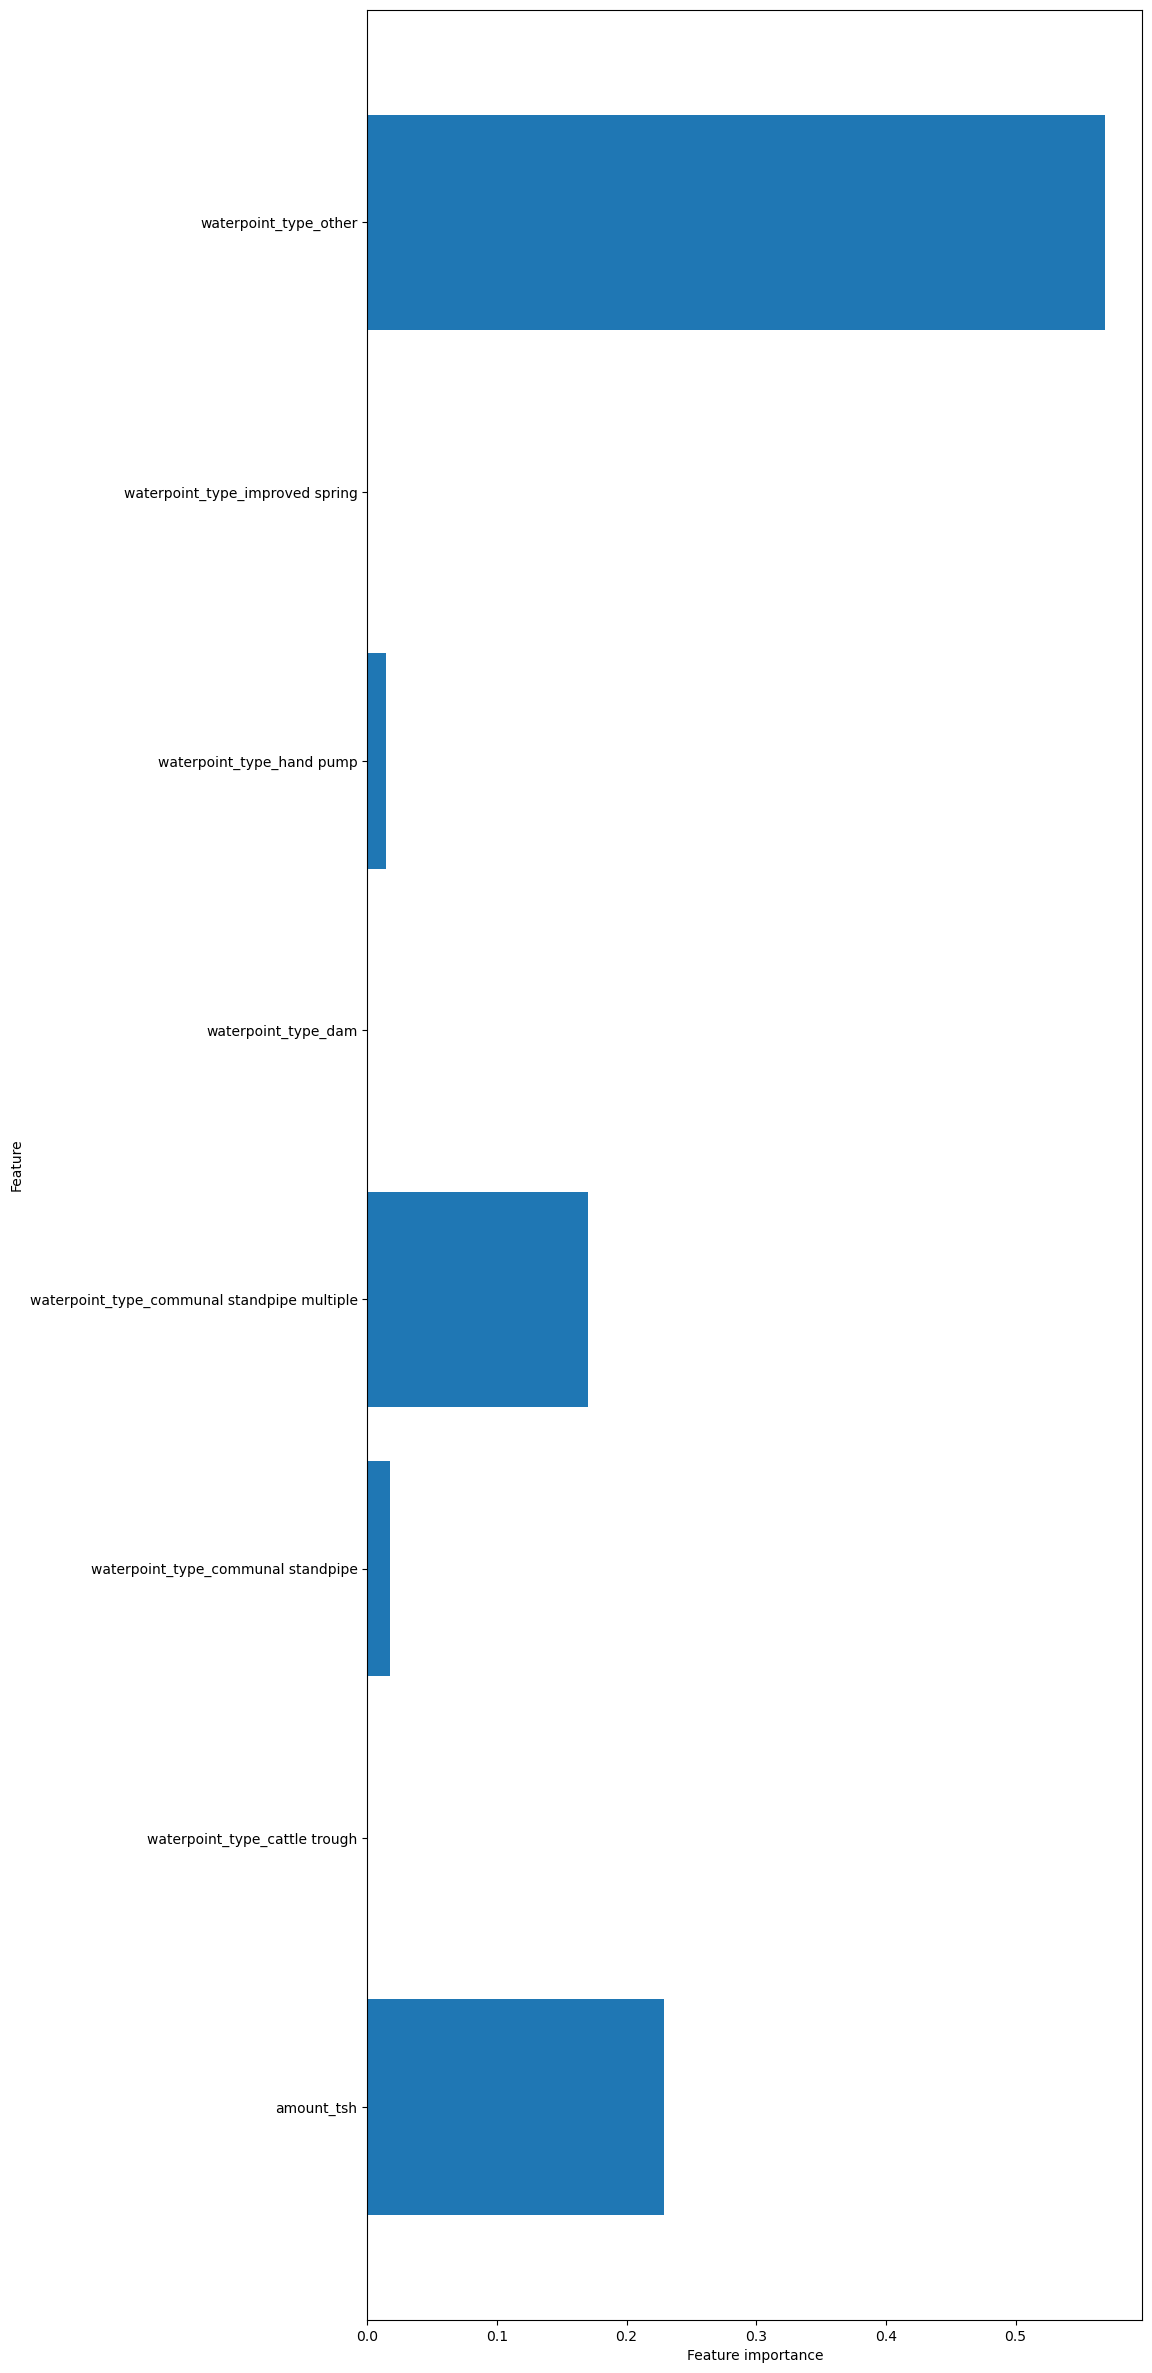

In [38]:
# Instantiate and fit a DecisionTreeClassifier with optimal parameters
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_impurity_decrease=0.0, 
                                  min_samples_split=5, random_state=1) 
tree_clf.fit(X_train, y_train)

plot_feature_importances(tree_clf)

In [39]:
myClassifiers = pd.Series(tree_clf.feature_importances_, index=X_train.columns)
myClassifiers.sort_values(ascending=False, inplace=True)
print(myClassifiers.head(20))

waterpoint_type_other                          0.569211
amount_tsh                                     0.228687
waterpoint_type_communal standpipe multiple    0.170412
waterpoint_type_communal standpipe             0.017246
waterpoint_type_hand pump                      0.014445
waterpoint_type_cattle trough                  0.000000
waterpoint_type_dam                            0.000000
waterpoint_type_improved spring                0.000000
dtype: float64


In [40]:
y_pred = tree_clf.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)
print('The Decision Tree model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Decision Tree model with OHE has an accuracy of 64.3 %


In [41]:
'quantity_dry', 'waterpoint_type_other', 'waterpoint_type_communal standpipe multiple', 'amount_tsh', 'basin_Lake Nyasa', 'construction_year', 'longitude', 'payment_type_per bucket', 'lga_Ngara', 'quantity_insufficient',

('quantity_dry',
 'waterpoint_type_other',
 'waterpoint_type_communal standpipe multiple',
 'amount_tsh',
 'basin_Lake Nyasa',
 'construction_year',
 'longitude',
 'payment_type_per bucket',
 'lga_Ngara',
 'quantity_insufficient')

In [42]:
#Using top 10 Feature Classifiers including Longitude
df10_long = data_onehot[['quantity_dry', 'waterpoint_type_other', 'waterpoint_type_communal standpipe multiple', 
                            'amount_tsh', 'basin_Lake Nyasa', 'construction_year', 'longitude', 
                            'payment_type_per bucket', 'lga_Ngara', 'quantity_insufficient','status_group']]

X = df10_long.drop('status_group', axis=1)
y = df10_long['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)

print('The Decision Tree model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Decision Tree model with OHE has an accuracy of 71.2 %


In [43]:
#Using top 10 Feature Classifiers EXCLUDING Longitude
df10_no_long = data_onehot[['quantity_dry', 'waterpoint_type_other', 'waterpoint_type_communal standpipe multiple',
                               'amount_tsh', 'basin_Lake Nyasa', 'construction_year', 'payment_type_per bucket', 
                               'lga_Ngara', 'quantity_insufficient','lga_Kahama', 'status_group']]

X = df10_no_long.drop('status_group', axis=1)
y = df10_no_long['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)

print('The Decision Tree model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Decision Tree model with OHE has an accuracy of 72.6 %


## Model 5: Random Forest with Top 20 Attributes | 79.4%

#### Almost all columns in dataset

In [44]:
#Assign X and y
X = data_onehot.drop(['status_group'], axis=1)
y = data_onehot['status_group']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

#instantiate RandomForest
forest = RandomForestClassifier(random_state=1, max_depth=20, n_estimators=50)

#fit to training
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)
print('The Random Forest model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Random Forest model with OHE has an accuracy of 81.5 %


In [45]:
#Random Forest accuracy score for training
forest.score(X_train, y_train)

0.8984593395968641

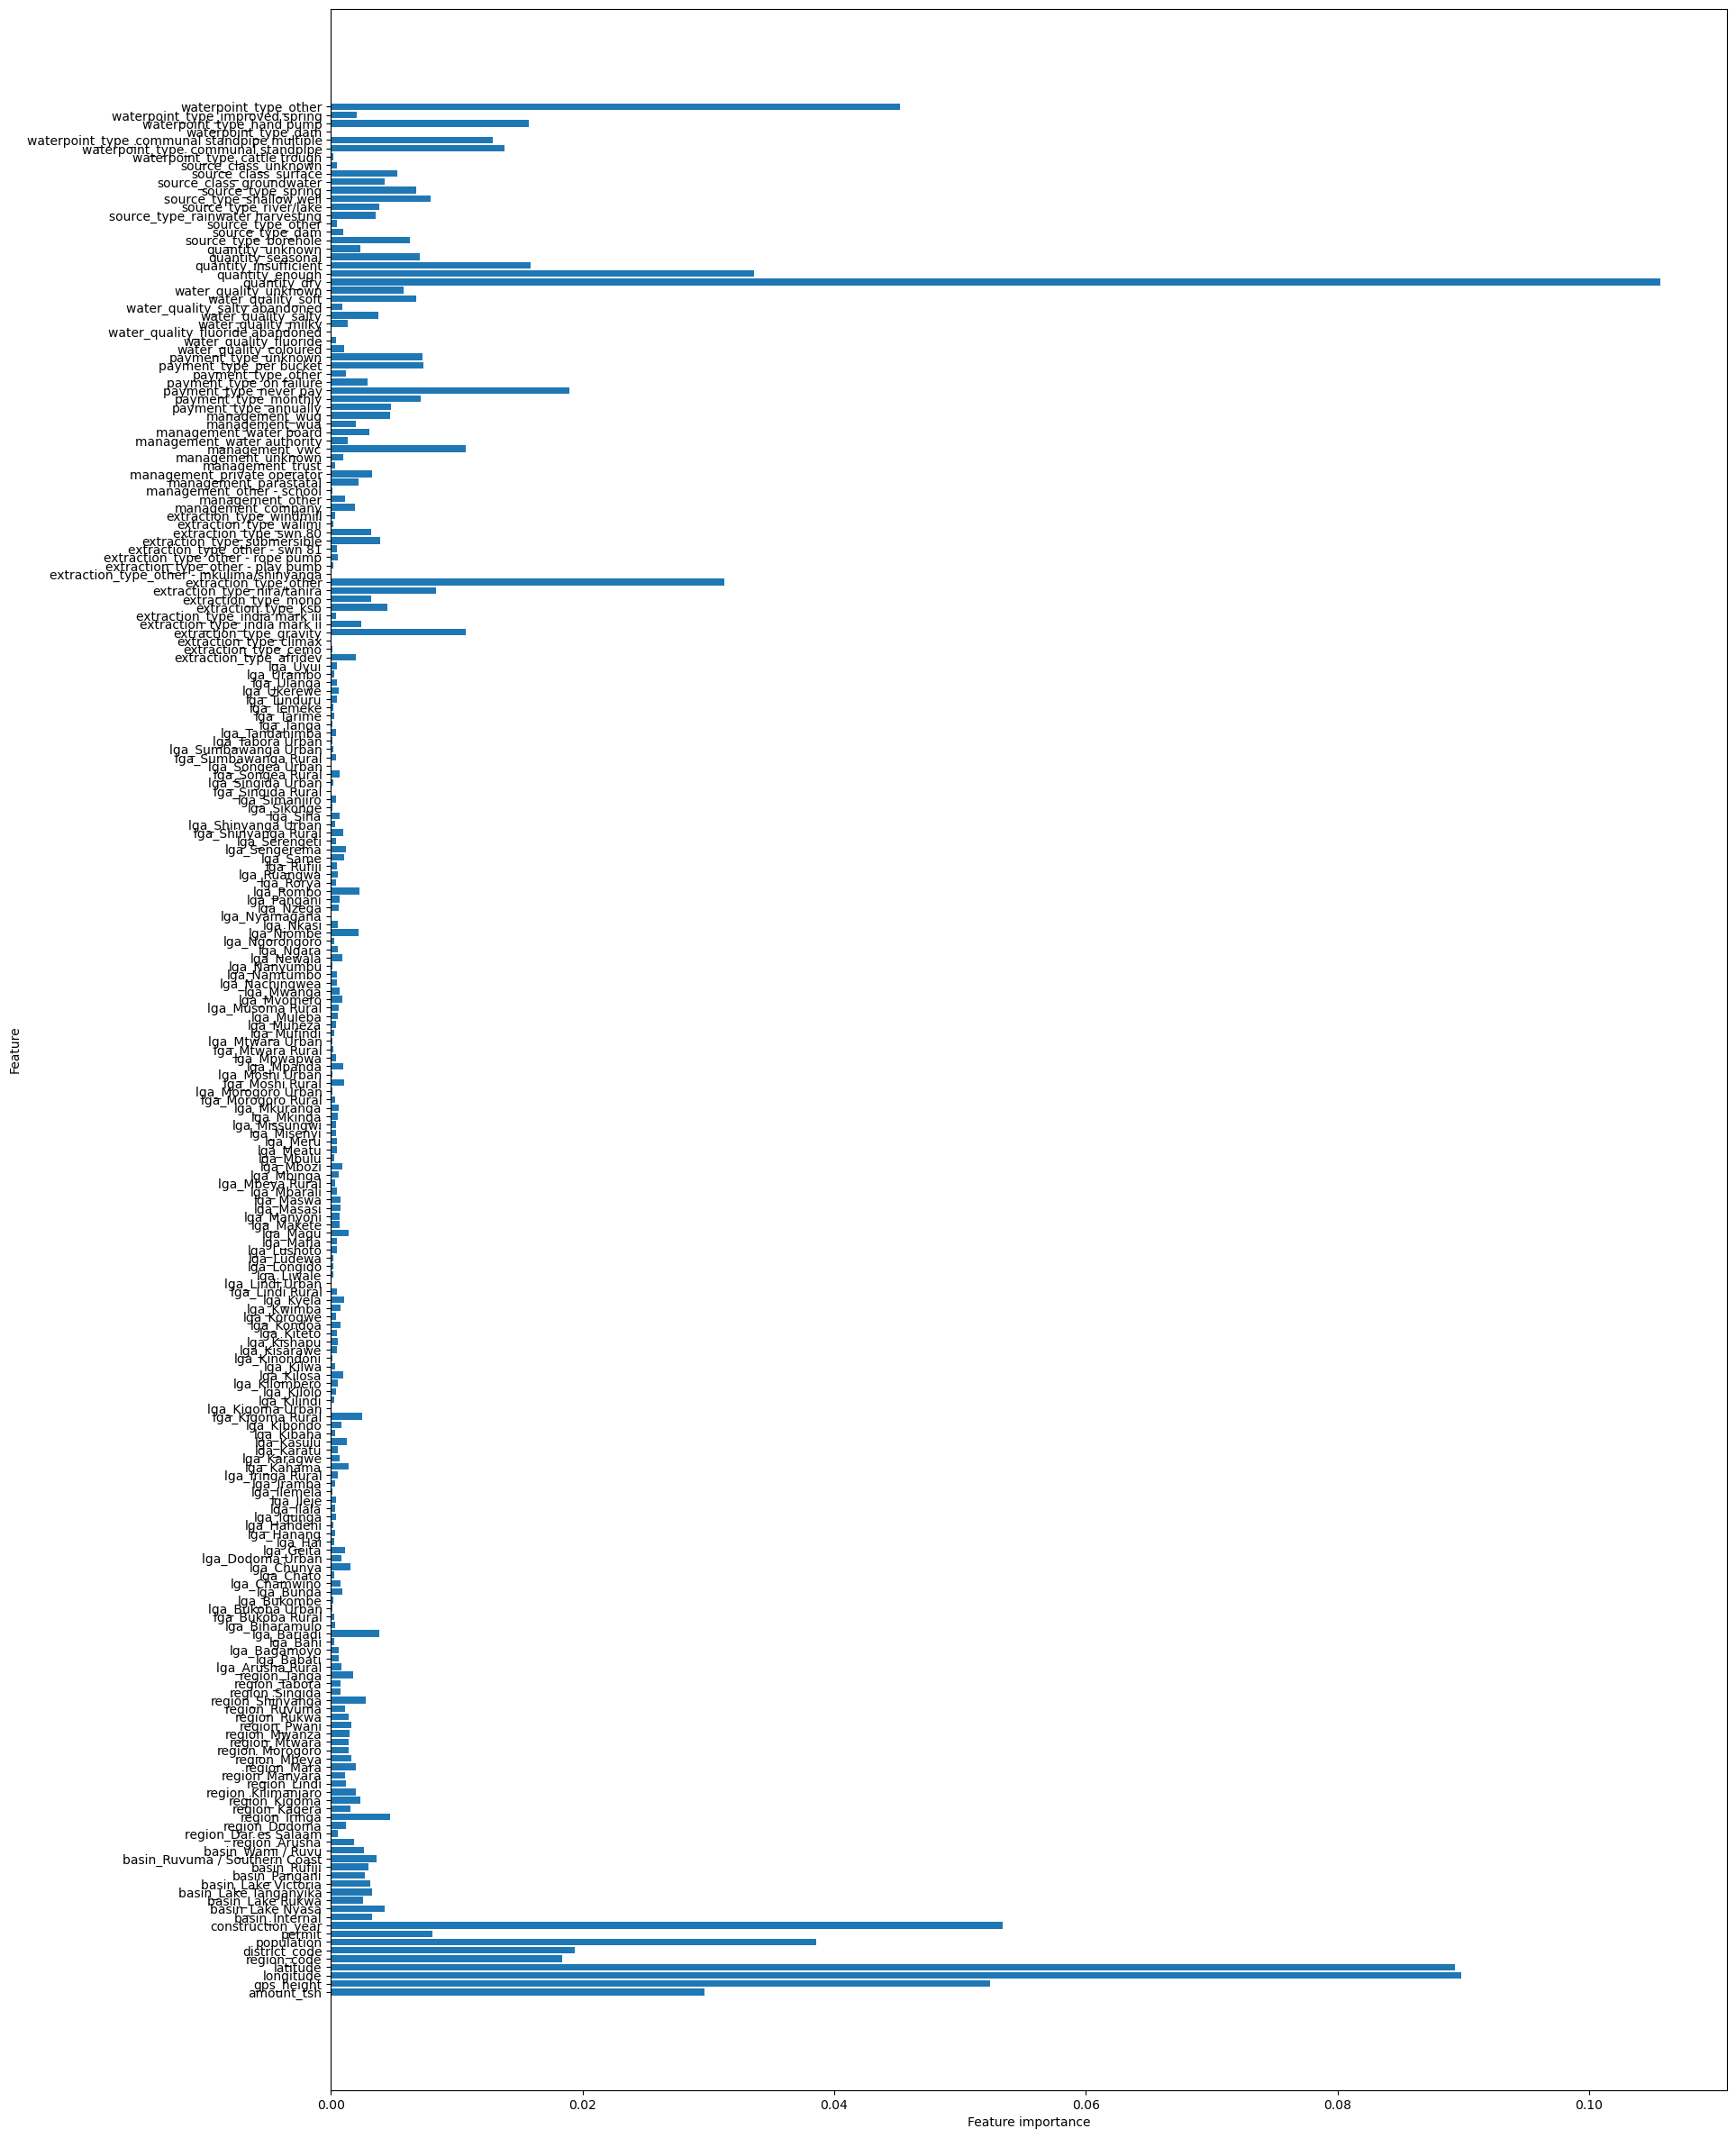

In [46]:
def plot_feature_importances(forest):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,30))
    plt.barh(range(n_features), forest.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

In [47]:
myClassifiers = pd.Series(forest.feature_importances_, index=X_train.columns)
myClassifiers.sort_values(ascending=False, inplace=True)
print(myClassifiers.head(22))

quantity_dry                                   0.105688
longitude                                      0.089805
latitude                                       0.089326
construction_year                              0.053396
gps_height                                     0.052412
waterpoint_type_other                          0.045206
population                                     0.038559
quantity_enough                                0.033649
extraction_type_other                          0.031302
amount_tsh                                     0.029660
district_code                                  0.019354
payment_type_never pay                         0.018986
region_code                                    0.018403
quantity_insufficient                          0.015854
waterpoint_type_hand pump                      0.015728
waterpoint_type_communal standpipe             0.013779
waterpoint_type_communal standpipe multiple    0.012900
management_vwc                                 0

### Top 10 Classifiers

#### Includes Longitude/Latitude

In [48]:
#Using top 10 Feature Classifiers including Longitude/Latitude
df10_latlong = data_onehot[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height', 
                            'waterpoint_type_other', 'population', 'quantity_enough', 'extraction_type_other', 
                            'amount_tsh', 'status_group']]

X = df10_latlong.drop('status_group', axis=1)
y = df10_latlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

forest = RandomForestClassifier(random_state=1, max_depth=20, n_estimators=50)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)

print('The Random Forest model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Random Forest model with OHE has an accuracy of 79.3 %


In [49]:
#Random Forest accuracy score for training
forest.score(X_train, y_train)

0.939823864472329

#### Excludes Longitude/Latitude

In [50]:
#Using top 10 Feature Classifiers EXCLUDING Longitude/Latitude
df10_no_latlong = data_onehot[['quantity_dry', 'construction_year', 'gps_height', 'waterpoint_type_other', 
                               'population', 'quantity_enough', 'extraction_type_other', 'amount_tsh', 
                               'district_code', 'payment_type_never pay', 'status_group']]

X = df10_no_latlong.drop('status_group', axis=1)
y = df10_no_latlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

forest = RandomForestClassifier(random_state=1, max_depth=20, n_estimators=50)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)

print('The Random Forest model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Random Forest model with OHE has an accuracy of 76.5 %


In [51]:
#Random Forest accuracy score for training
forest.score(X_train, y_train)

0.8740778107068542

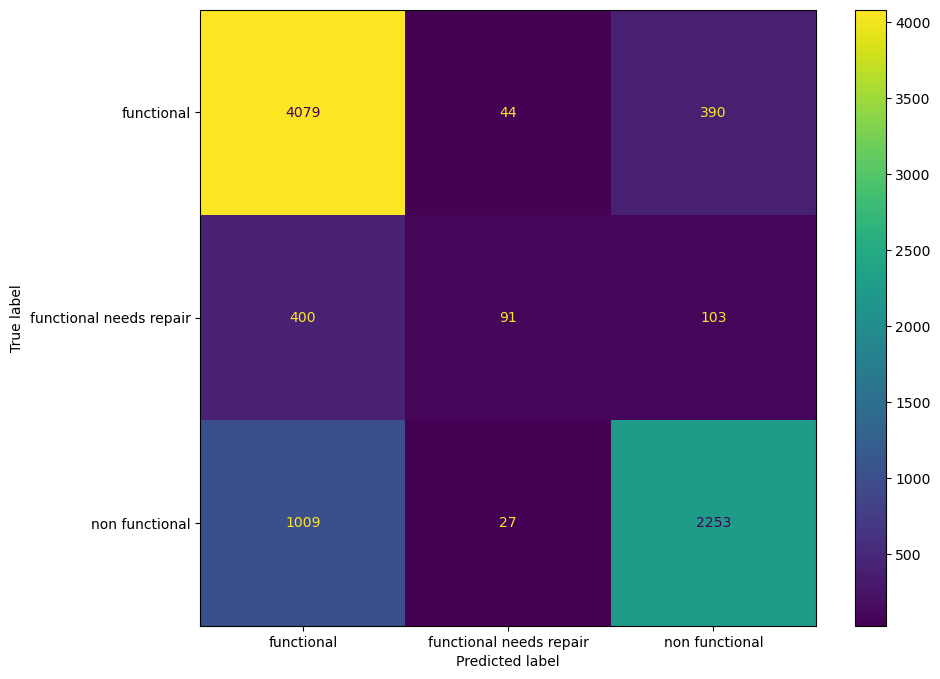

In [52]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=forest.classes_), display_labels=forest.classes_)
fig, ax = plt.subplots(figsize=(10,8))
cm_plot.plot(ax=ax)
plt.show()

### Top 20 Classifiers

#### Includes Longitude/Latitude

In [53]:
top20_df_withlatlong = data_onehot[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height', 
                        'waterpoint_type_other', 'population', 'quantity_enough', 'extraction_type_other', 
                        'amount_tsh', 'district_code', 'payment_type_never pay', 'region_code', 
                        'quantity_insufficient', 'waterpoint_type_hand pump', 'waterpoint_type_communal standpipe', 
                        'waterpoint_type_communal standpipe multiple', 'management_vwc', 'extraction_type_gravity', 
                        'extraction_type_nira/tanira', 'status_group']] 

X = top20_df_withlatlong.drop('status_group', axis=1)
y = top20_df_withlatlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

forest = RandomForestClassifier(random_state=1, max_depth=15, n_estimators=50)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)

print('The Random Forest model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Random Forest model with OHE has an accuracy of 80.5 %


In [54]:
#Random Forest accuracy score for training
forest.score(X_train, y_train)

0.8671416861088341

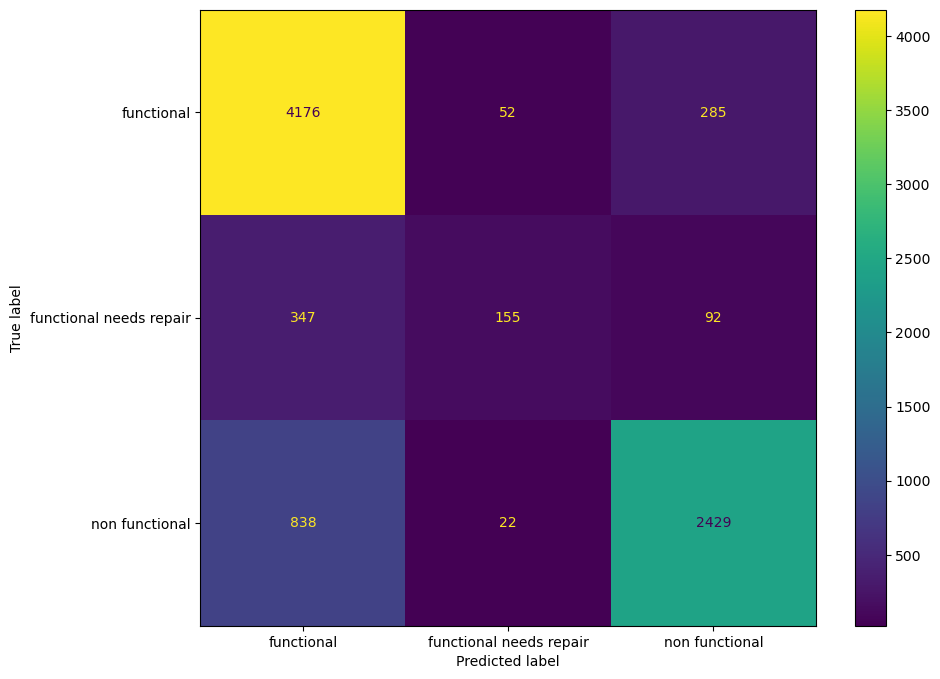

In [55]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=forest.classes_), display_labels=forest.classes_)
fig, ax = plt.subplots(figsize=(10,8))
cm_plot.plot(ax=ax)
plt.show()

#### Excludes Longitude/Latitude

In [56]:
top20_df_nolatlong = data_onehot[['quantity_dry','construction_year', 'gps_height','waterpoint_type_other', 'population', 
                        'quantity_enough', 'extraction_type_other', 'amount_tsh', 'district_code', 
                        'payment_type_never pay', 'region_code', 'quantity_insufficient', 'waterpoint_type_hand pump',
                        'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 
                        'management_vwc', 'extraction_type_gravity', 'extraction_type_nira/tanira', 
                        'permit','source_type_shallow well', 'status_group']] 

X = top20_df_nolatlong.drop('status_group', axis=1)
y = top20_df_nolatlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

forest = RandomForestClassifier(random_state=1, max_depth=15, n_estimators=50)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_dt_dummies = accuracy_score(y_test, y_pred)

print('The Random Forest model with OHE has a train accuracy of', round(forest.score(X_train, y_train), 3)*100, '%')
print('The Random Forest model with OHE has an accuracy of', round(acc_dt_dummies, 3)*100, '%')

The Random Forest model with OHE has a train accuracy of 84.5 %
The Random Forest model with OHE has an accuracy of 79.4 %


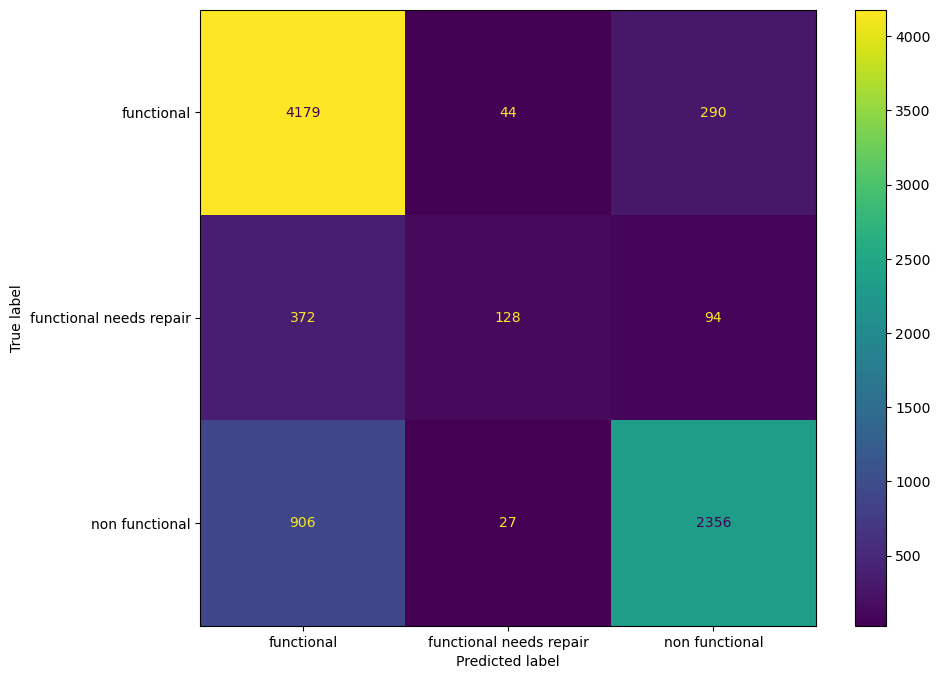

In [57]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=forest.classes_), display_labels=forest.classes_)
fig, ax = plt.subplots(figsize=(10,8))
cm_plot.plot(ax=ax)
plt.show()

# OVERSAMPLING AND UNDERSAMPLING 

## Model 6: Undersampling Model | 70.7%

The Random Forest model with undersampling and OHE has a train accuracy of 91.9 %
The Random Forest model with undersampling and OHE has an accuracy of 70.7 %


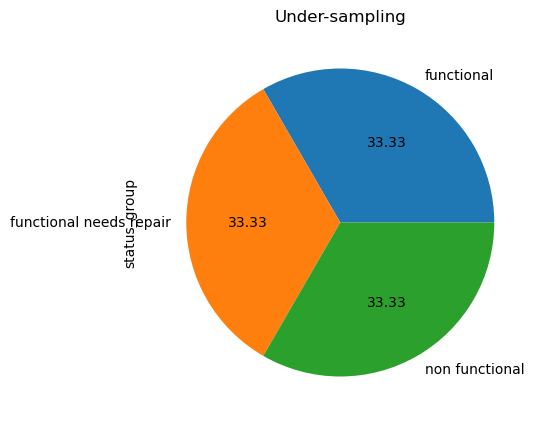

In [58]:
# Getting the top 20 parameter columns
top20_df_nolatlong = data_onehot[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height',
                                  'waterpoint_type_other', 'population', 
                        'quantity_enough', 'extraction_type_other', 'amount_tsh', 'district_code', 
                        'payment_type_never pay', 'region_code', 'quantity_insufficient', 'waterpoint_type_hand pump',
                        'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 
                        'management_vwc', 'extraction_type_gravity', 'extraction_type_nira/tanira', 
                        'permit','source_type_shallow well', 'status_group']] 

X = top20_df_nolatlong.drop('status_group', axis=1)
y = top20_df_nolatlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

####################### UNDERSAMPLING ########################
sampling_strategy = "not minority"
autopct = "%.2f"

fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=1)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
y_train_us.value_counts().plot.pie(autopct=autopct, ax=axs)
axs.set_title("Under-sampling")
##############################################################

forest = RandomForestClassifier(random_state=1, max_depth=15, n_estimators=50)

forest.fit(X_train_us, y_train_us)

y_pred = forest.predict(X_test)

acc_dt_dummies_us = accuracy_score(y_test, y_pred)

y_pred_train_us = forest.predict(X_train_us)
acc_dt_dummies_train_us = accuracy_score(y_train_us, y_pred_train_us)

print('The Random Forest model with undersampling and OHE has a train accuracy of', round(acc_dt_dummies_train_us, 3)*100, '%')
print('The Random Forest model with undersampling and OHE has an accuracy of', round(acc_dt_dummies_us, 3)*100, '%')

## Model 7: Oversampling Model - 84.3%

The Random Forest model with oversampling and OHE has a train accuracy of 87.2 %
The Random Forest model with oversampling and OHE has an accuracy of 84.3 %


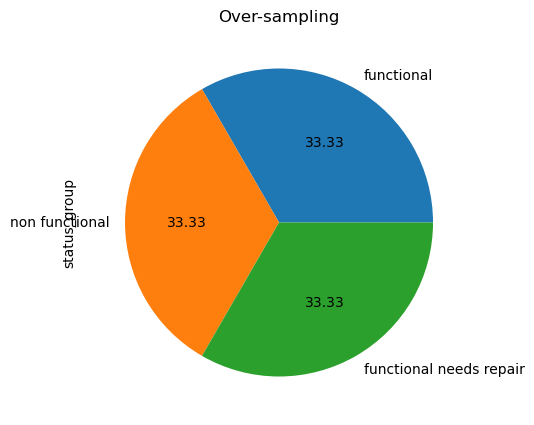

In [59]:
top20_df_nolatlong = data_onehot[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height', 
                                  'waterpoint_type_other', 'population', 
                        'quantity_enough', 'extraction_type_other', 'amount_tsh', 'district_code', 
                        'payment_type_never pay', 'region_code', 'quantity_insufficient', 'waterpoint_type_hand pump',
                        'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 
                        'management_vwc', 'extraction_type_gravity', 'extraction_type_nira/tanira', 
                        'permit','source_type_shallow well', 'status_group']] 

X = top20_df_nolatlong.drop('status_group', axis=1)
y = top20_df_nolatlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

####################### OVERSAMPLING ########################
sampling_strategy = "not minority"
autopct = "%.2f"

fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
sampling_strategy = "not majority"
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=1)
X_train_os, y_train_os = ros.fit_resample(X, y)
y_train_os.value_counts().plot.pie(autopct=autopct, ax=axs)
axs.set_title("Over-sampling")
##############################################################

forest = RandomForestClassifier(random_state=1, max_depth=15, n_estimators=50)

forest.fit(X_train_os, y_train_os)

y_pred = forest.predict(X_test)

acc_dt_dummies_os = accuracy_score(y_test, y_pred)

y_pred_train_os = forest.predict(X_train_os)
acc_dt_dummies_train_os = accuracy_score(y_train_os, y_pred_train_os)
print('The Random Forest model with oversampling and OHE has a train accuracy of', round(acc_dt_dummies_train_os, 4)*100, '%')
print('The Random Forest model with oversampling and OHE has an accuracy of', round(acc_dt_dummies_os, 3)*100, '%')

## Model 8 (final): Hyperparameter Tuning with Oversampling | 86.4%

Using GridSearchCV to test 160 combinations of hyperparameters with 4 folds.

Best resulting values:
- max_depth          --> 25
- n_estimators       --> 100
- min_samples_leaf   --> 5
- criterion          --> entropy

#### Splits and Oversampling

In [60]:
top20_df_nolatlong = data_onehot[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height', 
                                  'waterpoint_type_other', 'population', 
                        'quantity_enough', 'extraction_type_other', 'amount_tsh', 'district_code', 
                        'payment_type_never pay', 'region_code', 'quantity_insufficient', 'waterpoint_type_hand pump',
                        'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 
                        'management_vwc', 'extraction_type_gravity', 'extraction_type_nira/tanira', 
                        'permit','source_type_shallow well', 'status_group']] 

X = top20_df_nolatlong.drop('status_group', axis=1)
y = top20_df_nolatlong['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)

######################## OVERSAMPLING ########################
# fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
sampling_strategy = "not majority"
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=1)
X_train_os, y_train_os = ros.fit_resample(X, y)
y_train_os.value_counts().plot.pie(autopct=autopct, ax=axs)
##############################################################

forest_tuning = RandomForestClassifier(random_state=1)

#### Setting params for GridSearchCV

In [61]:
params = {
    'max_depth': [10, 15, 20, 25],
    'n_estimators': [25, 50, 75, 100],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [62]:
grid_search = GridSearchCV(estimator=forest_tuning, 
                           param_grid=params, 
                           cv=4,                            # cross validation fold
                           n_jobs=-1,                       # n_jobs = -1 uses all processors
                           verbose=1,                       # minimum output messages
                           scoring = "accuracy") 

#### Implementing grid search by fitting, scoring, and picking the best estimator

In [63]:
grid_search.fit(X_train_os, y_train_os)

Fitting 4 folds for each of 160 candidates, totalling 640 fits


KeyboardInterrupt: 

In [ ]:
# Get 5 best mean test scores

score_df.nlargest(5,"mean_test_score")

In [ ]:
# Get the best model

rf_best = grid_search.best_estimator_
rf_best

In [ ]:
# Not overfit. Train accuracy is close to test accuracy, relative to other models

print('The Tuned Random Forest model with oversampling and OHE has a train accuracy of', round(accuracy_score(y_train_os, rf_best.predict(X_train_os)), 4)*100, '%')
print('The Tuned Random Forest model with oversampling and OHE has an accuracy of', round(accuracy_score(y_test, rf_best.predict(X_test)), 3)*100, '%')

# -------------------------------- END OF MODELS --------------------------------

# Plots

### Number of Wells by Functionality

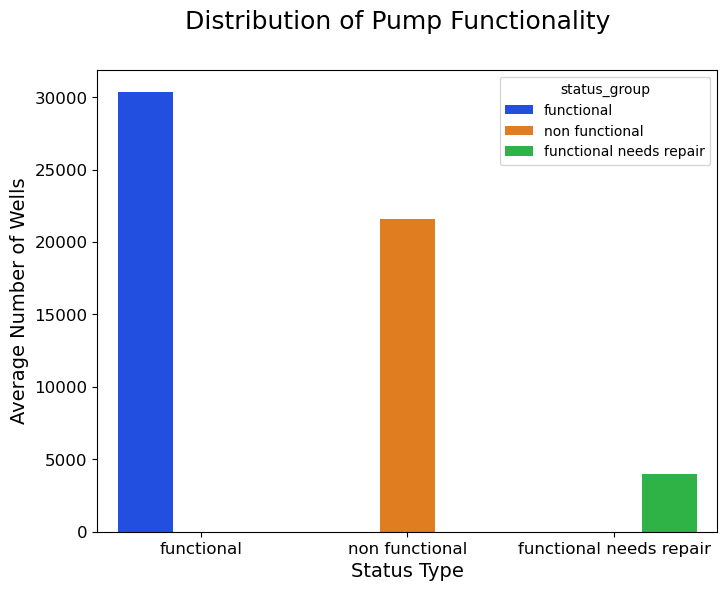

In [64]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(data=train_df, x='status_group', hue="status_group", palette='bright')

fig.suptitle('Distribution of Pump Functionality', fontsize=18)
plt.xlabel('Status Type', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
plt.tick_params(labelsize='large')
plt.show()

fig.savefig('plots/training_set_values.png')

We see a large imbalance in the dataset. Over half of the dataset contains fully functional wells whereas a third consists of non functional wells. Less than tenth of the data consists of functional wells in need of repair.

### Construction Year

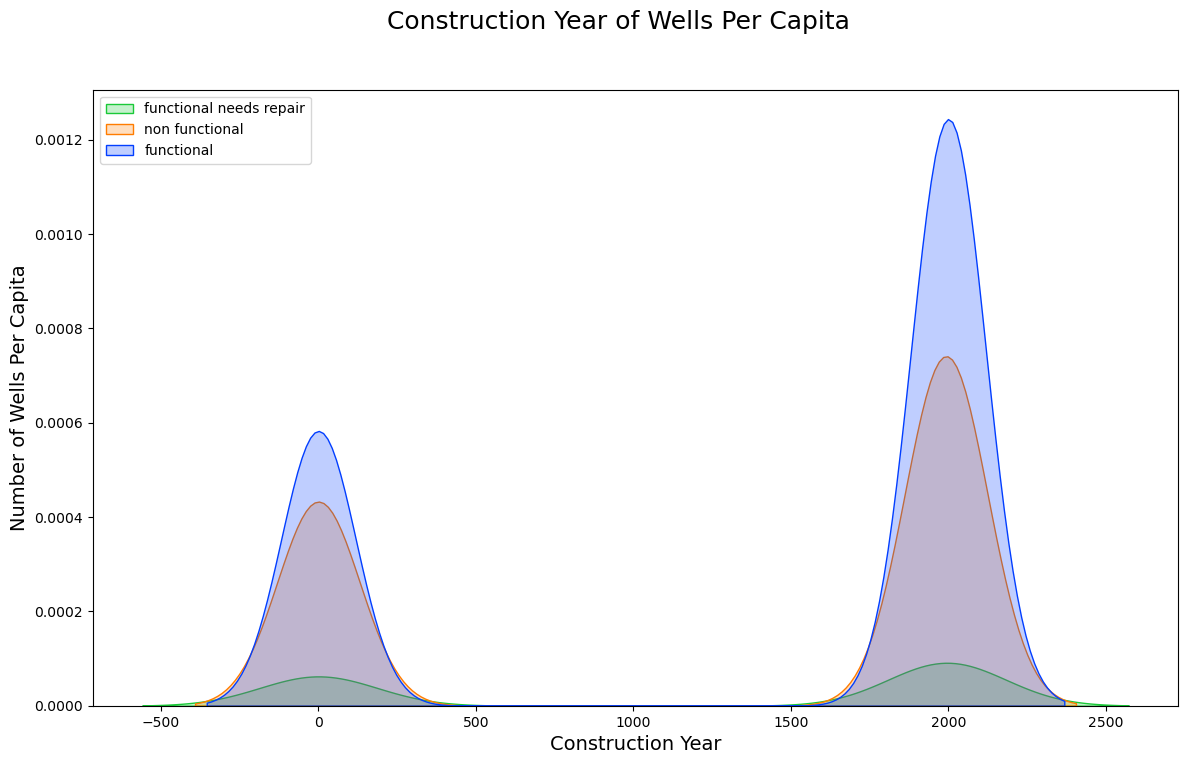

In [65]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.kdeplot(data=train_df, x='construction_year', hue='status_group', palette='bright', fill=True)
fig.suptitle('Construction Year of Wells Per Capita', fontsize=18)
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Number of Wells Per Capita', fontsize=14)
plt.legend(loc='upper left', labels=['functional needs repair', 'non functional', 'functional'])
plt.show();

fig.savefig('plots/constructionyear_areaplot_include0.png')

A significant amount of our data seems to have 0 as the construction year - likely the construction year is unknown. Let's exclude those wells and focus on the ones with accurate construction years.

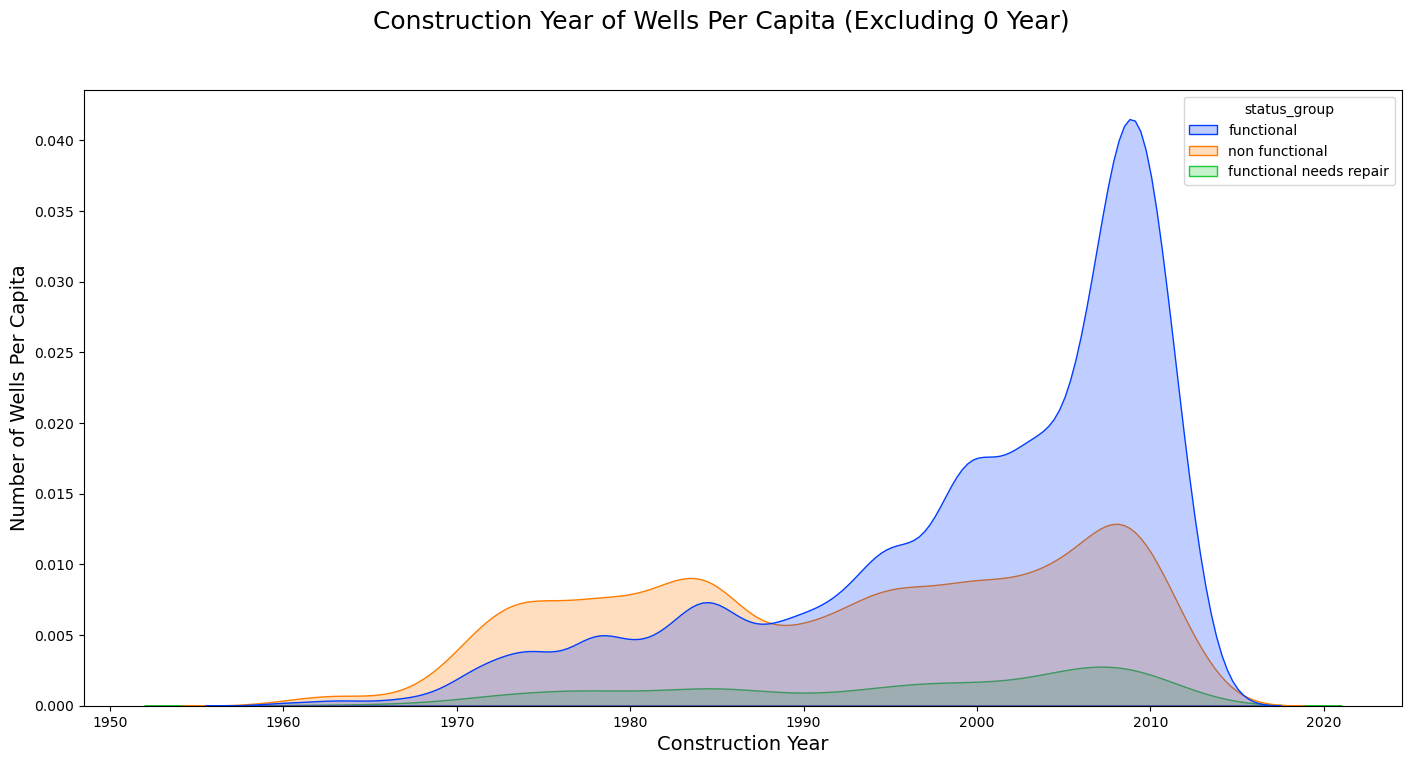

In [66]:
#Select wells without 'construction_year' = 0
df_actual_construction_years = train_df.loc[train_df['construction_year'] != 0]

fig, ax = plt.subplots(figsize=(17,8))
ax = sns.kdeplot(data=df_actual_construction_years, x='construction_year', hue='status_group', palette='bright', fill=True)
fig.suptitle('Construction Year of Wells Per Capita (Excluding 0 Year)', fontsize=18)
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Number of Wells Per Capita', fontsize=14)
#plt.legend(loc='upper left', labels=['functional needs repair', 'non functional', 'functional'])
plt.show();

fig.savefig('plots/constructionyear_areaplot_exclude0.png')

A majority of the functional wells in the dataset have been built in the last twenty years. However, there are more older wells that are non functional - in particular, those build before 1990. There is a consistent amount of functional wells in need of repair over the years.

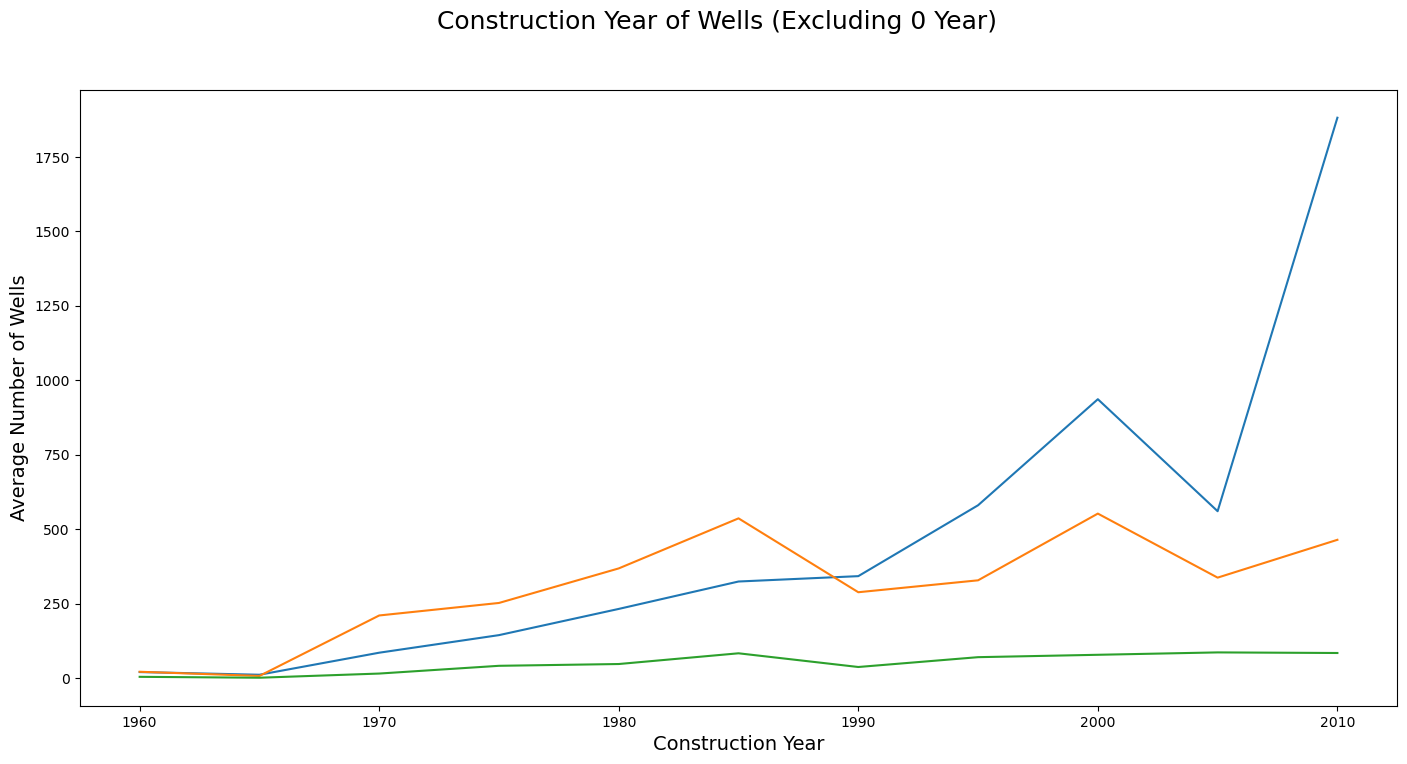

In [67]:
#Create dataset with only construction_year and status_group
years_status = df_actual_construction_years[['construction_year', 'status_group']]

#Dummy the status_group
years_status_dum = pd.get_dummies(years_status, columns=['status_group'])

#Group the sum of the status group dummies by construction year 
year_max = years_status_dum.groupby('construction_year').sum()

#select 5 year intervals 
year_stat_5intervals = year_max.iloc[::5, :]

fig, ax = plt.subplots(figsize=(17,8))
ax = sns.lineplot(data=year_stat_5intervals, x='construction_year', y='status_group_functional', palette='bright')

ax = sns.lineplot(data=year_stat_5intervals, x='construction_year', y='status_group_non functional', palette='bright')

ax = sns.lineplot(data=year_stat_5intervals, x='construction_year', y='status_group_functional needs repair', palette='bright')

fig.suptitle('Construction Year of Wells (Excluding 0 Year)', fontsize=18)
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
#plt.legend(loc='upper left', labels=['functional needs repair', 'non functional', 'functional'])
plt.show();

fig.savefig('plots/constructionyear_lineplot_exclude0.png')

This graph depicts the same as the graphs of construction year above, but as a line graph.

### Population

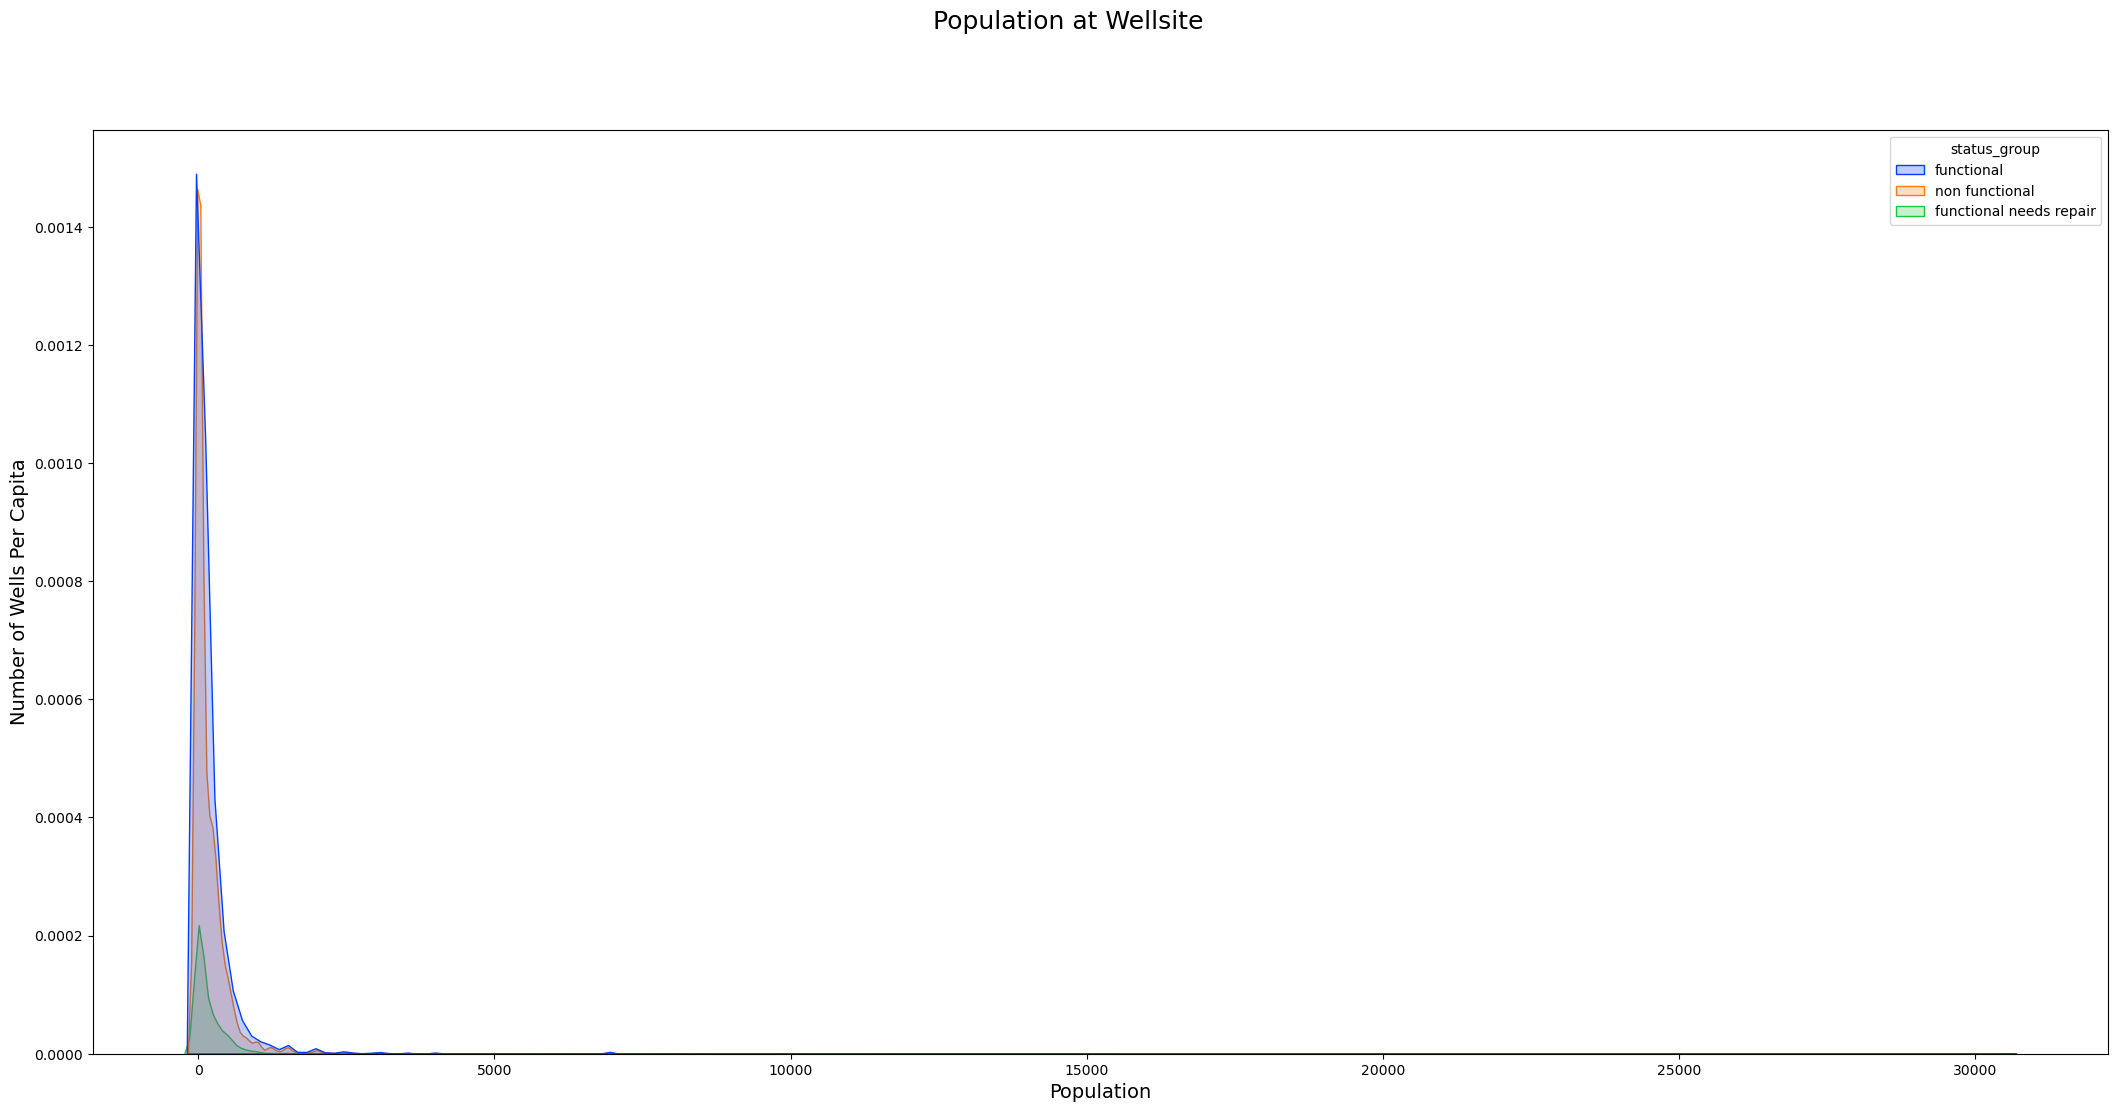

In [68]:
fig, ax = plt.subplots(figsize=(26,12))
ax = sns.kdeplot(data=train_df, x='population', hue='status_group', palette='bright', fill=True)
fig.suptitle('Population at Wellsite', fontsize=18)
plt.xlabel("Population", fontsize=14)
plt.ylabel('Number of Wells Per Capita', fontsize=14)
plt.show()

fig.savefig('plots/population_all.png')

It seems like there is a large difference in the population at wellsites. Let's hone in on the populations to get a better and closer look at the numbers, specifically those less than 1000.

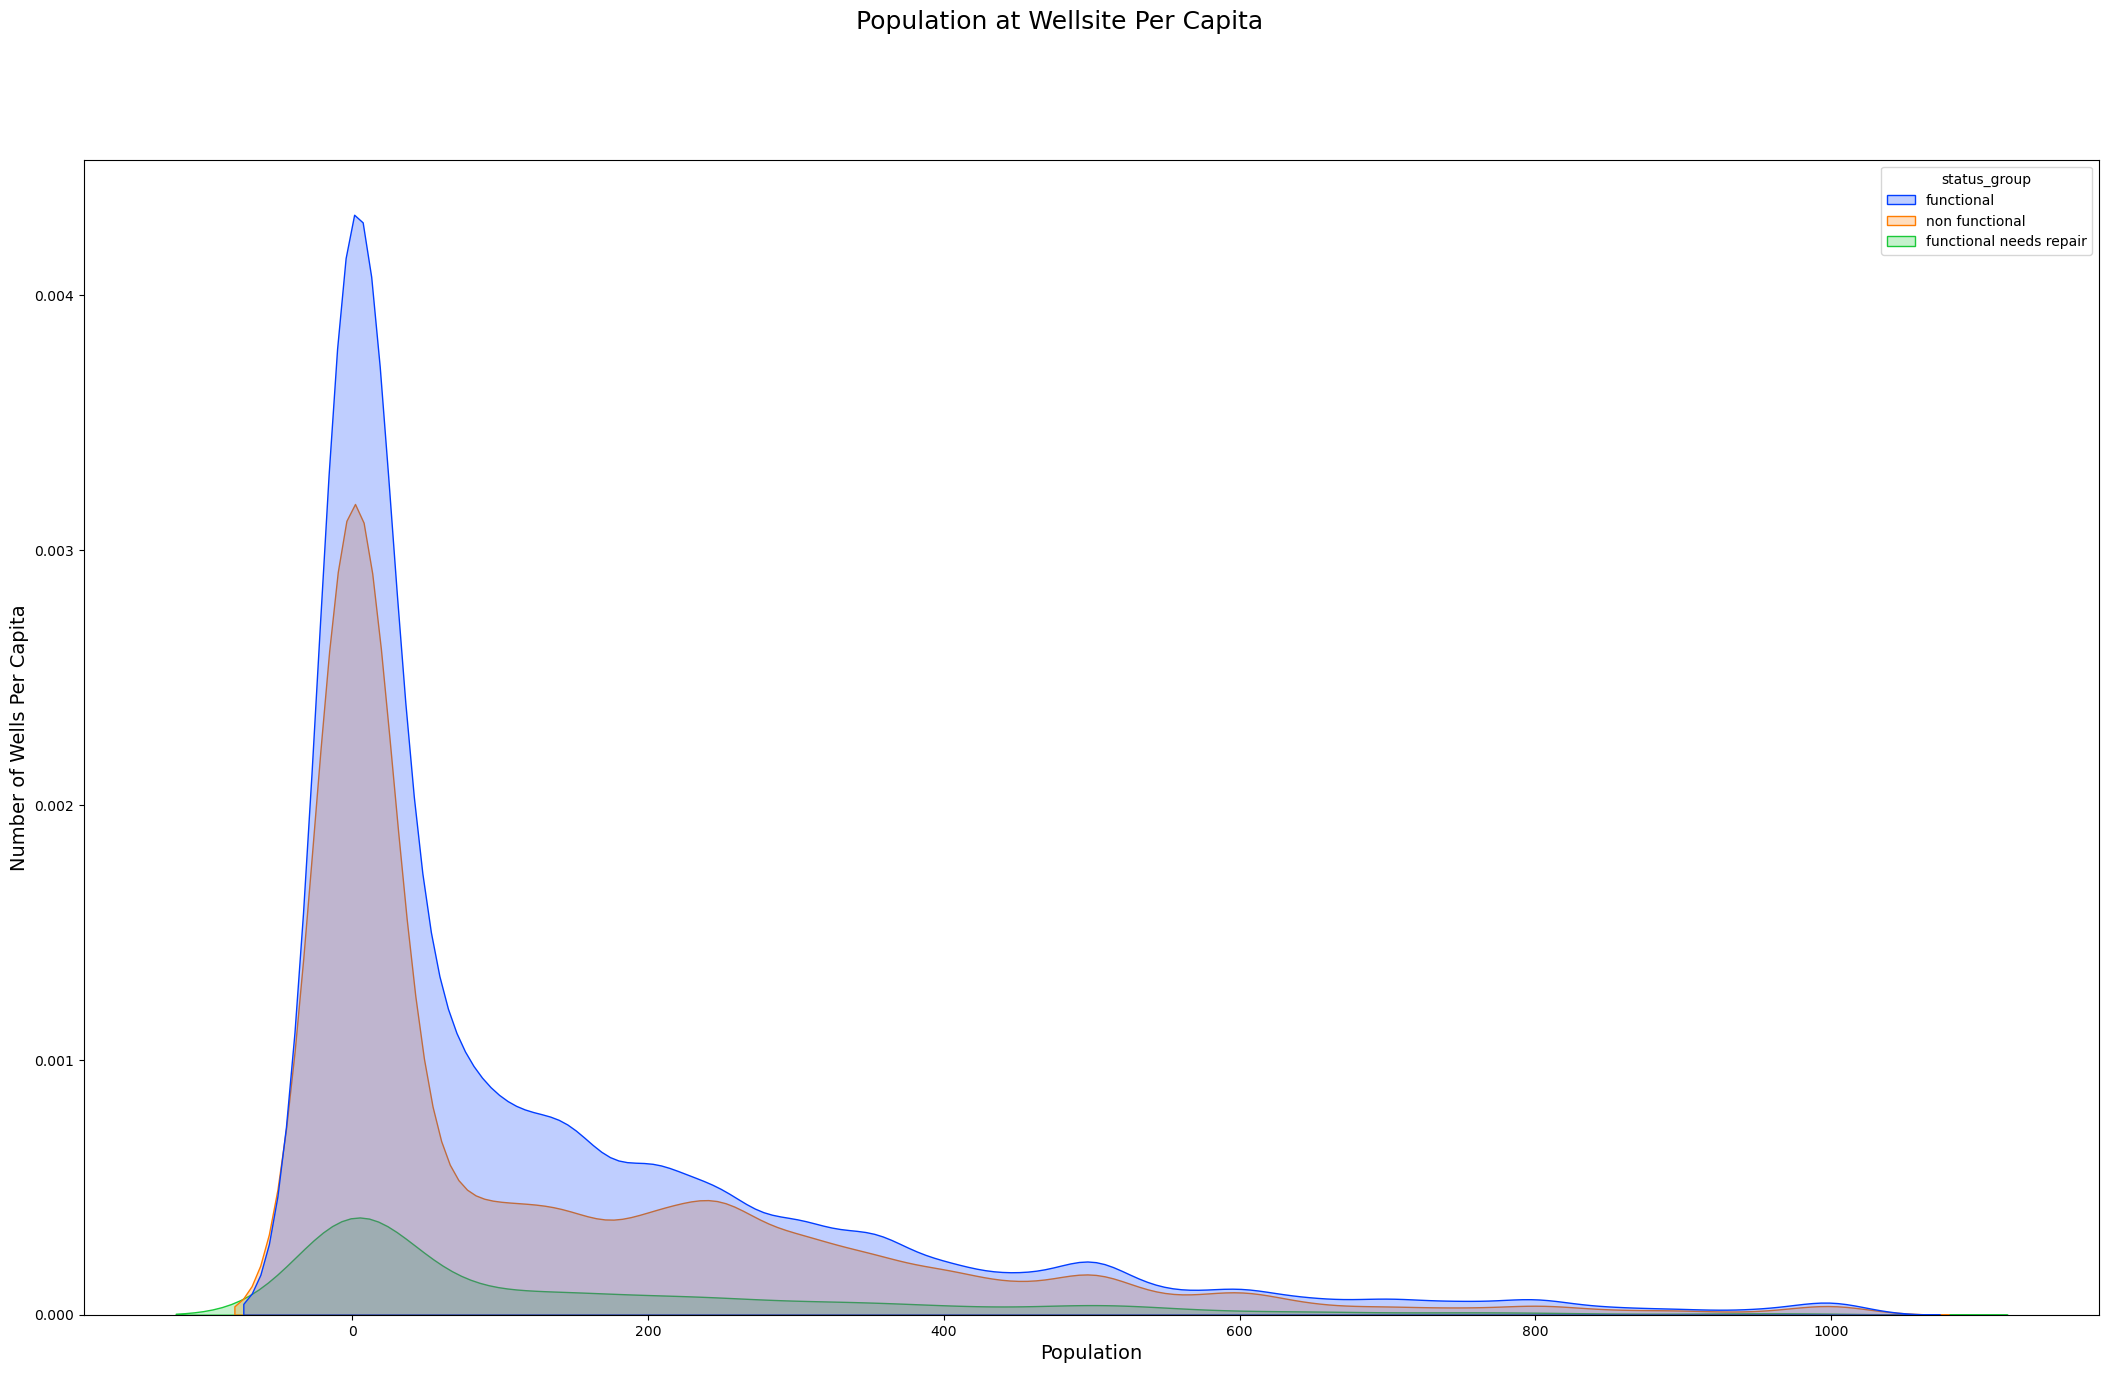

In [69]:
#Exclude populations of greater than 1000.
pop_df = train_df.loc[train_df['population'] <= 1000]

fig, ax = plt.subplots(figsize=(26,15))
ax = sns.kdeplot(data=pop_df, x='population', hue='status_group', palette='bright', fill=True)
fig.suptitle('Population at Wellsite Per Capita', fontsize=18)
plt.xlabel('Population', fontsize=14)
plt.ylabel('Number of Wells Per Capita', fontsize=14)
plt.show();

fig.savefig('plots/population_1000less.png')

A significant amount of water wells have a population of 0, which shows that the locals would have to travel from their villages in order to get to the water wells. There does not seem to be large populations near water wells, whether it be functional or non functional.

### Payment Type

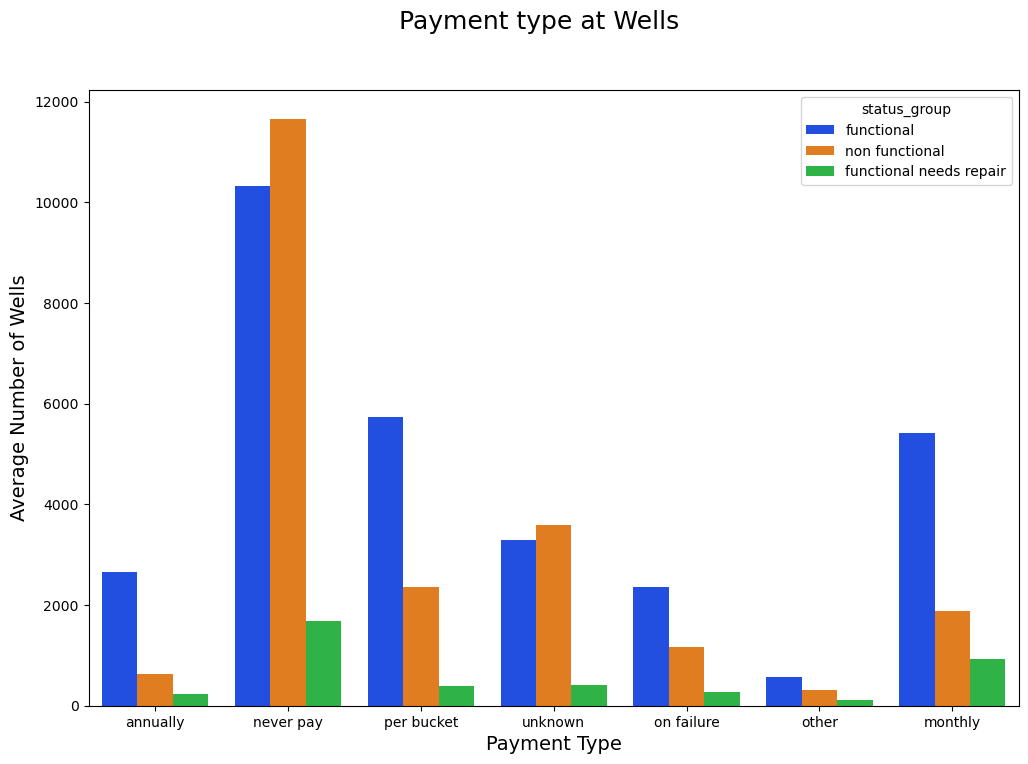

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_df, x='payment_type', hue="status_group", palette='bright')

fig.suptitle('Payment type at Wells', fontsize=18)
plt.xlabel('Payment Type', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
plt.show();

fig.savefig('plots/payments.png')

There are significantly more functional water wells that locals never have to pay for, however there are even more that are non functional. Following that, wells that require some payment such as monthly or per bucket have an increased amount of functional wells.

### Number of Wells in the North vs. South

Let's see if there's a different in number of wells in North versuses South Tanzania. We've elected to use the median value in latitude as the distinguishing value between North and South.

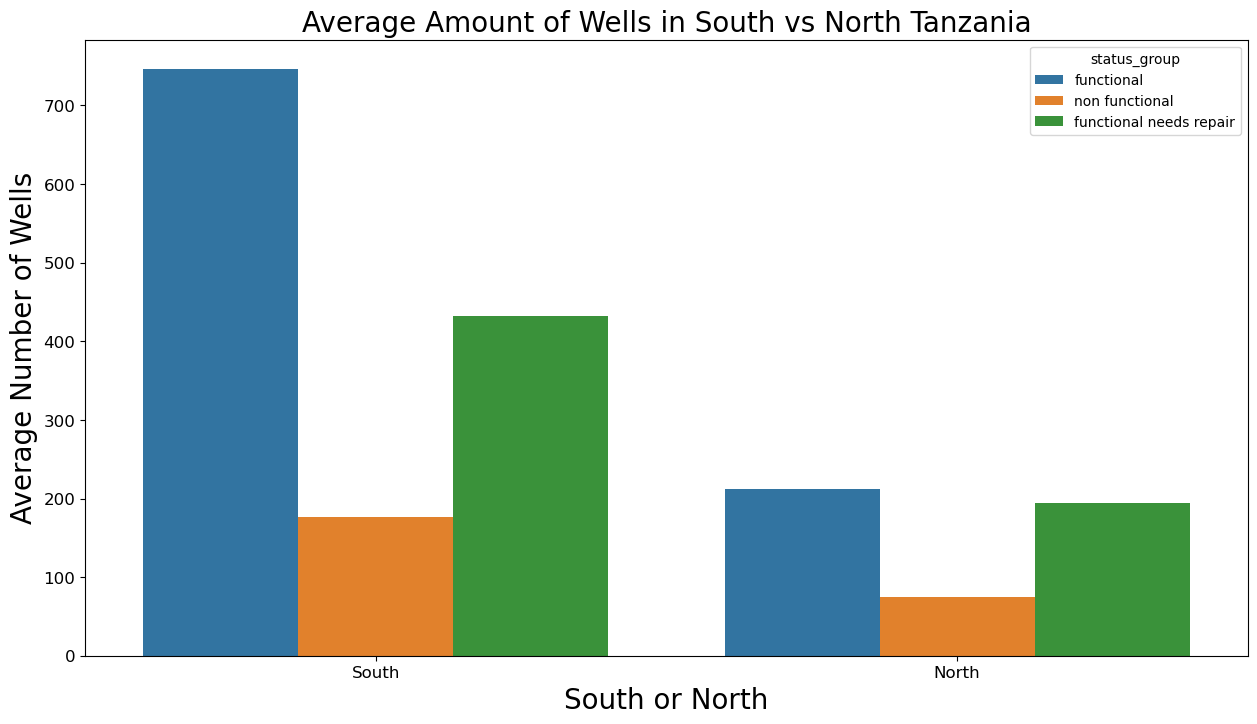

In [72]:
#Create a new column distinguishing what's North or South
train_df['North_South'] = np.where(train_df['latitude'] >= -5.1, 'North', 'South')

fig, ax = plt.subplots(figsize = (15 , 8))
sns.barplot(data=train_df, x='North_South', y='amount_tsh', hue="status_group", ci = None)
ax.set_xlabel('South or North', fontsize = 20)
ax.set_ylabel('Average Number of Wells', fontsize = 20)
ax.set_title('Average Amount of Wells in South vs North Tanzania', fontsize = 20)
plt.ticklabel_format(style='plain',axis='y')
ax.tick_params(axis='both', which='major', labelsize=12);

fig.savefig('plots/northsouth_averagewells.png')

There are more wells south of latitude -5.1 than there are in the north. However, there is a significant difference in the average number of functional and functional needs repairs wells in the South vs the North.

### Quality of Water

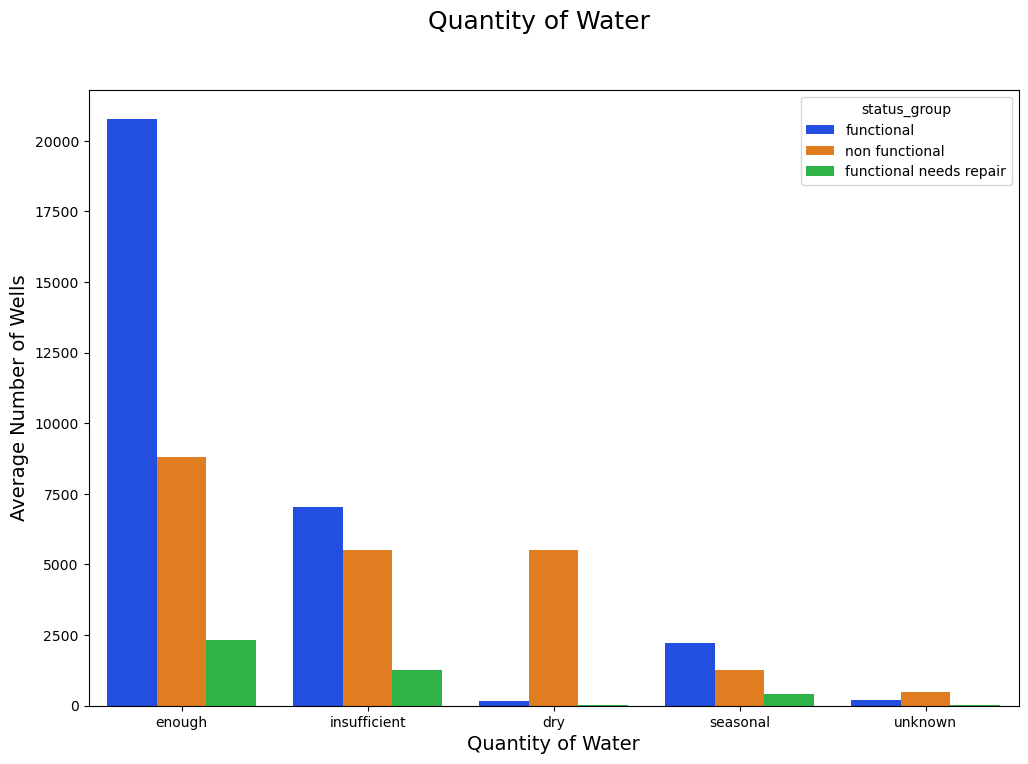

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_df, x='quantity', hue="status_group", palette='bright')

fig.suptitle('Quantity of Water', fontsize=18)
plt.xlabel('Quantity of Water', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
plt.show();

fig.savefig('plots/quantity.png')

Significantly more functional wells have enough water, however the amount of water to be considered enough is unknown. The greatest average number of non functional wells are also of enough quantity. It is expected that a number of non functional wells are dry.

### Type of Waterpoint

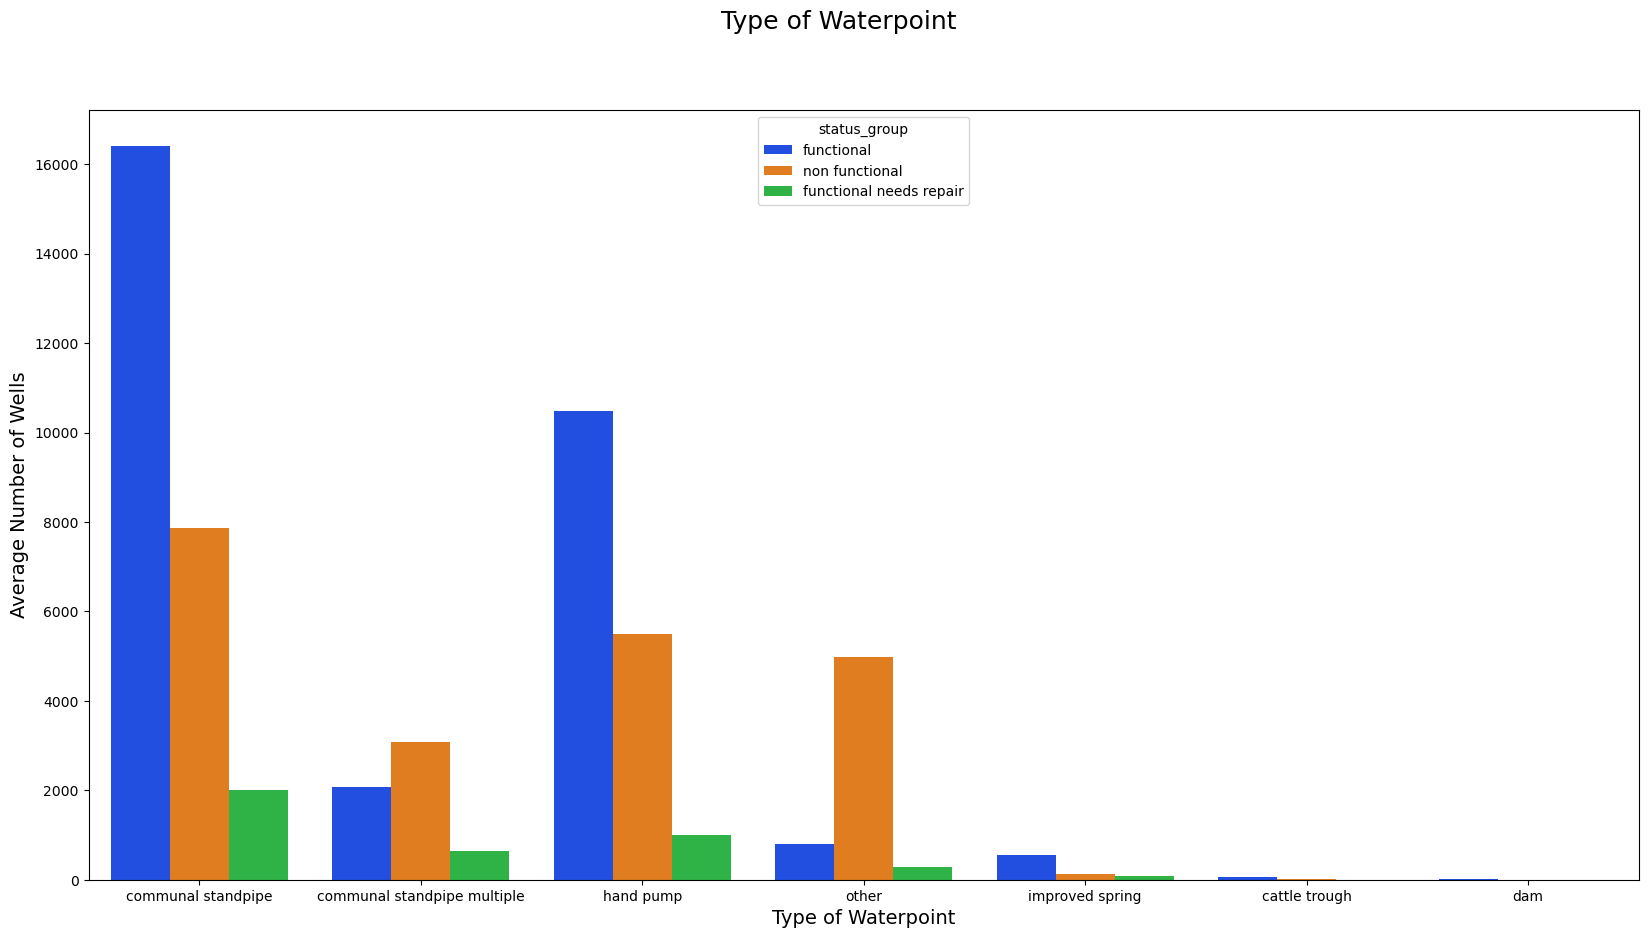

In [78]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(data=train_df, x='waterpoint_type', hue="status_group", palette='bright')

fig.suptitle('Type of Waterpoint', fontsize=18)
plt.xlabel('Type of Waterpoint', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
plt.show();

fig.savefig('plots/waterpoints.png')

A majority of the waterpoints are man-made, with a significant amount of functional wells being a communal standpipe or hand pump. However these types of waterpoints also have the largest number of non functioning wells.

### Source Type

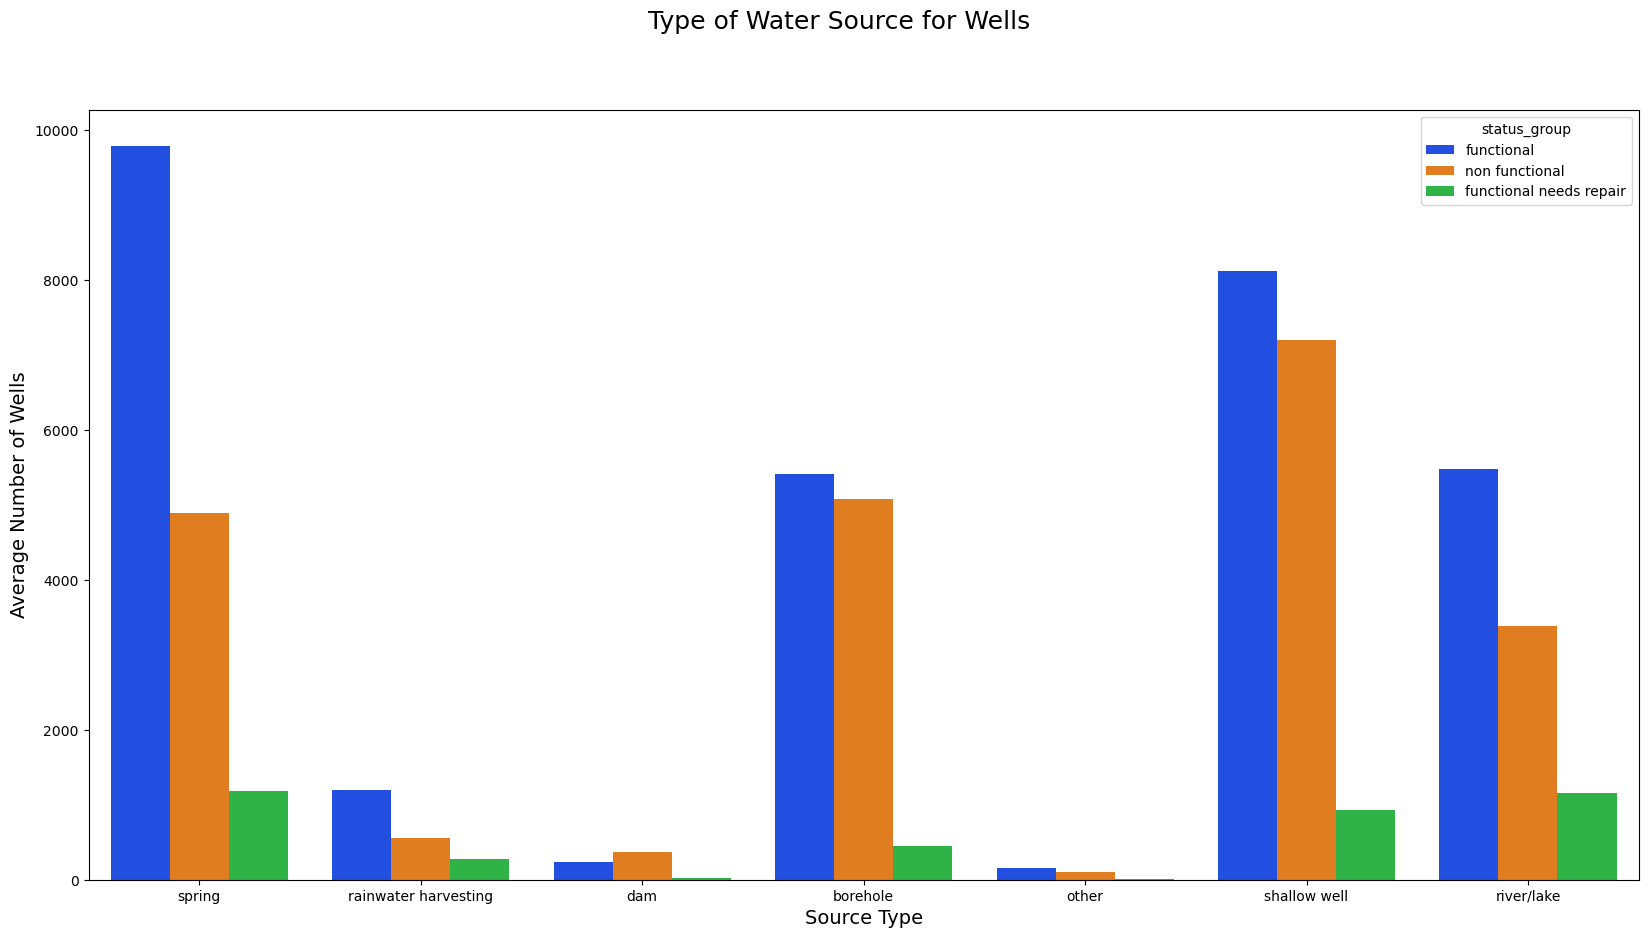

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(data=train_df, x='source_type', hue="status_group", palette='bright')

fig.suptitle('Type of Water Source for Wells', fontsize=18)
plt.xlabel('Source Type', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
plt.show();

fig.savefig('plots/source.png')

The significant amount of wells are sourced from exposed bodies of water, such as a spring or river/lake. A borehole is a deep hole made into the ground, which can be created by NGOs to extract water. However, it can be inferred that these boreholes may not have been visited post construction. 

### Basin

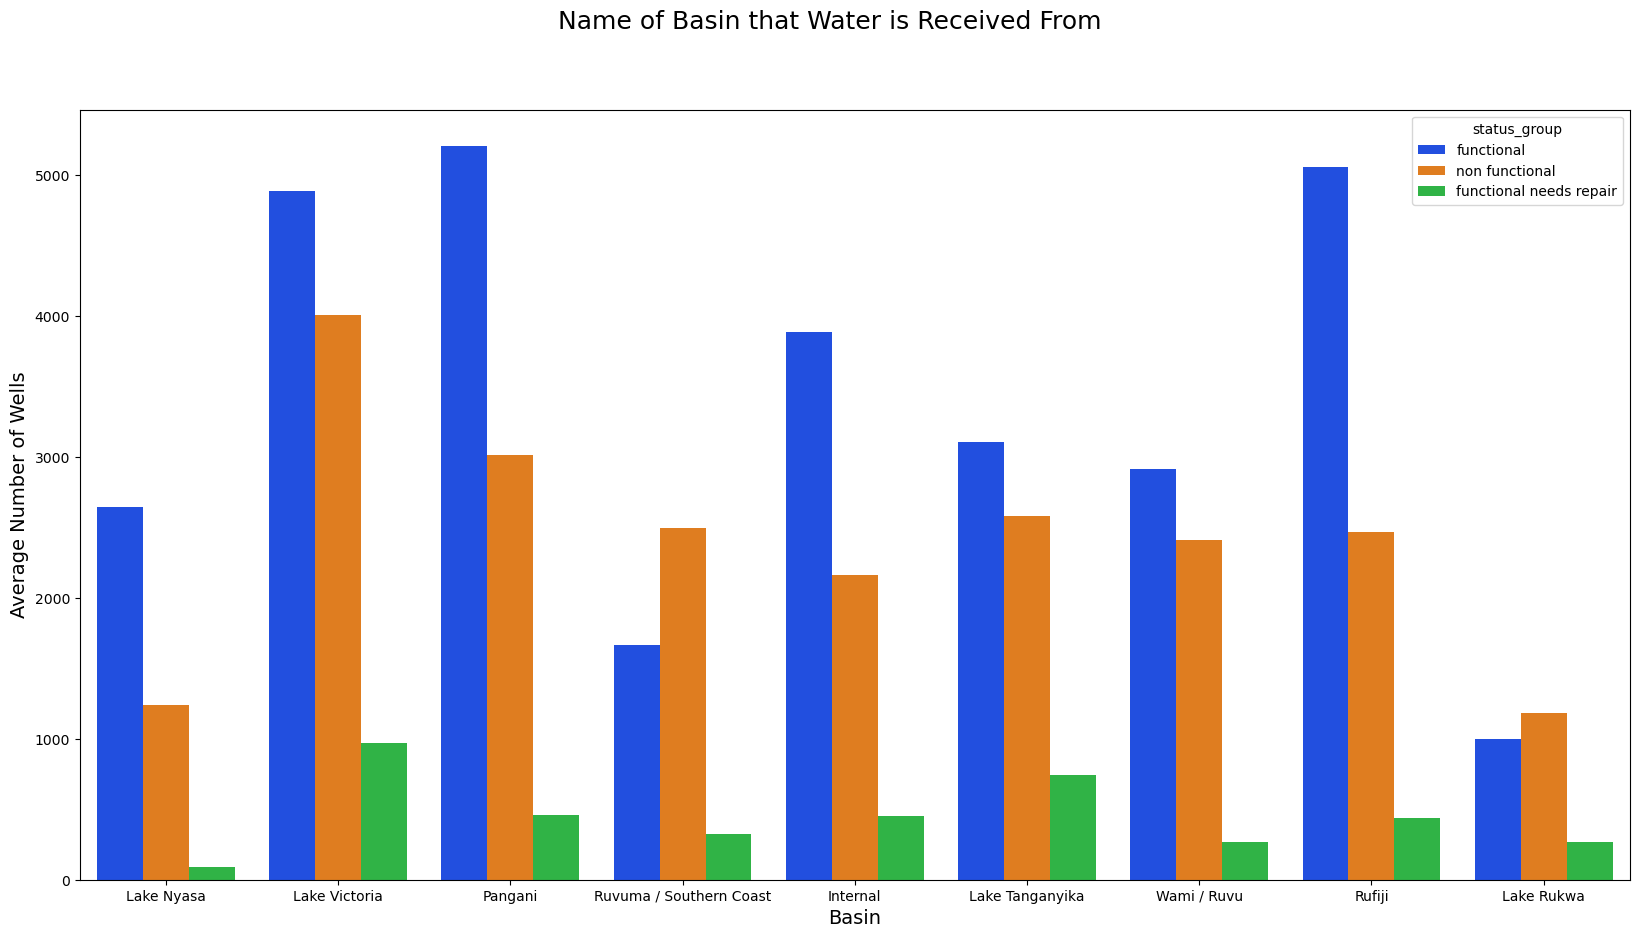

In [80]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(data=train_df, x='basin', hue="status_group", palette='bright')

fig.suptitle('Name of Basin that Water is Received From', fontsize=18)
plt.xlabel('Basin', fontsize=14)
plt.ylabel('Average Number of Wells', fontsize=14)
plt.show();

fig.savefig('plots/basin.png')

A majority of the functional wells receive water from the Pangani, Rufiji, and Lake Victoria basin. Although a lot of functional wells receive water from Lake Victoria, many non functional wells are also located around this lake. 

# ---------------------------------- END OF NOTEBOOK --------------------------------

# COMPETITION SUBMISSIONS

Predicting on the test data and creating the csv file

Uses the most reccent random forest fit

#### Submission OHE

In [67]:
#What are the categorical columns
categorical = ['basin', 'region', 'lga', 'extraction_type', 
               'management', 'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 
               'waterpoint_type']

#What are the continous columns
continuous = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 
              'permit', 'construction_year']


submit_cat_df = test_vals[categorical]
submit_cont_df = test_vals[continuous]

#instantiate OHE
submit_ohe = OneHotEncoder()

#fit_transform
submit_X_cat = submit_ohe.fit_transform(submit_cat_df).toarray()

submit_X_cat = pd.DataFrame(submit_X_cat, columns = submit_ohe.get_feature_names_out(categorical))

#Reset the indexes 
submit_X_cat = submit_X_cat.reset_index(drop=True)
submit_cont_df = submit_cont_df.reset_index(drop=True)

#combine the OHE categorical and continuous data back into one dataset
submit_data_onehot = pd.concat([submit_cont_df,submit_X_cat], axis=1, ignore_index=True)

submit_data_onehot.columns =list(submit_cont_df.columns) + list(submit_X_cat.columns)

In [109]:
submit_data_onehot['permit'].fillna(True, inplace=True)  # Filling missing permit data with True (do false next time)

test_vals_submit = submit_data_onehot[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height','waterpoint_type_other', 
                                       'population', 'quantity_enough', 'extraction_type_other', 'amount_tsh', 
                                       'district_code', 'payment_type_never pay', 'region_code', 
                                       'quantity_insufficient', 'waterpoint_type_hand pump', 
                                       'waterpoint_type_communal standpipe', 
                                       'waterpoint_type_communal standpipe multiple', 'management_vwc', 
                                       'extraction_type_gravity', 'extraction_type_nira/tanira', 'permit', 
                                       'source_type_shallow well']] 

y_pred_submit = rf_best.predict(test_vals_submit[['quantity_dry', 'longitude', 'latitude', 'construction_year', 'gps_height',
                                               'waterpoint_type_other', 'population', 'quantity_enough',
                                               'extraction_type_other', 'amount_tsh', 'district_code',
                                               'payment_type_never pay', 'region_code', 'quantity_insufficient',
                                               'waterpoint_type_hand pump', 'waterpoint_type_communal standpipe',
                                               'waterpoint_type_communal standpipe multiple', 'management_vwc',
                                               'extraction_type_gravity', 'extraction_type_nira/tanira', 'permit',
                                               'source_type_shallow well']])

In [113]:
submission3_df = pd.concat([test_vals['id'].reset_index(drop=True), 
                            pd.Series(y_pred_submit).reset_index(drop=True)], 
                           axis=1).rename(columns={0:'status_group'})
submission3_df.rename(columns={0:'status_group'})

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


### Creating submission csv files

In [114]:
sub_name = 'ohe_oversample_random_forest_gridsearch_best'
submission3_df.to_csv('submissions/submission' + sub_name + '.csv', index=False)  